In [ ]:
!pip install openpyxl
!pip install kneed
!pip install -U sentence-transformers
!pip install pandas dask
!pip install parallelbar
# !conda install numba & conda install cudatoolkit -> conda search numba


In [1]:
import re 
import pickle
import sys
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.cluster import KMeans, MiniBatchKMeans
from kneed import KneeLocator

from sklearn.metrics.cluster import v_measure_score, homogeneity_score, completeness_score

from tqdm import tqdm
# import multiprocessing
tqdm.pandas()
# pool = multiprocessing.Pool()

## upgrading sklearn to the 1.3.2 version, as it only supports HDBSCAN from that version onwards
# !conda update conda # non-interactive here, should run on jupyterhub.
# But best to install through conda so it downloads all the necessary libraries too
# !conda install scikit-learn=1.3.2
import sklearn
sklearn.__version__ # upgrade to 1.3.2

from sklearn.cluster import DBSCAN, HDBSCAN

In [2]:
features_df = pd.read_csv("/home/jovyan/calculated_files/subcat_features.csv")
layered_descriptions_filtered = pd.read_csv("/home/jovyan/calculated_files/layered_desc_filtered.csv")

In [3]:
features_df.drop(['layer_1', 'layer_2', 'layer_3', 'layer_4'], inplace=True, axis=1)

In [4]:
layered_descriptions_filtered['concatenated'] =  layered_descriptions_filtered[['Bezeichnung', 'Webbezeichnung', 'Detailinformation']].fillna('').agg(' '.join, axis=1)

layered_descriptions_filtered['concatenated'] = layered_descriptions_filtered['concatenated'].apply(lambda x: x.strip())

# Word-embedding clustering

## Sentence transformer

In [46]:
concat_merged_ds = layered_descriptions_filtered['concatenated'].copy()

In [10]:
# importing the SBERT models 

distil_v1_st_model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v1')
distil_v2_st_model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')
paraphrase_miniLM_st_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
paraphrase_mpnet_st_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

### distil v1 embeddings

In [6]:
# embedded_df_distil_v1 = concat_merged_ds.progress_apply(distil_v1_st_model.encode)
# np.save('calculated_files/embedded_df_sentence_transformer_distil_v1.npy', embedded_df_sent_trans)
embedded_df_distil_v1 = np.load('calculated_files/embedded_df_sentence_transformer_distil_v1.npy', allow_pickle=True)

### distil v2 embeddings

In [30]:
# embedded_df_distil_v2 = concat_merged_ds.progress_apply(distil_v2_st_model.encode)
# np.save('calculated_files/embedded_df_distil_v2.npy', embedded_df_distil_v2)
embedded_df_distil_v2 = np.load('calculated_files/embedded_df_distil_v2.npy', allow_pickle=True)

### paraphrase miniLM embeddings

In [39]:
# embedded_df_paraph_miniLM = concat_merged_ds.progress_apply(paraphrase_miniLM_st_model.encode)
# np.save('calculated_files/embedded_df_paraph_miniLM.npy', embedded_df_paraph_miniLM)
embedded_df_paraph_miniLM = np.load('calculated_files/embedded_df_paraph_miniLM.npy', allow_pickle=True)

### paraphrase mpnet embeddings

In [50]:
# embedded_df_paraph_mpnet = concat_merged_ds.progress_apply(paraphrase_mpnet_st_model.encode)
# np.save('calculated_files/embedded_df_paraph_mpnet.npy', embedded_df_paraph_mpnet)
embedded_df_paraph_mpnet = np.load('calculated_files/embedded_df_paraph_mpnet.npy', allow_pickle=True)

## Clustering

### K-Means

In [50]:
kmeans_kwargs = {
    "init":'k-means++',
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42, 
}

sc_X = StandardScaler()

#### distil v1

In [12]:
X_train = sc_X.fit_transform(list(embedded_df_distil_v1))

# A list holds the SSE values for each k
sse_scaled_distil1 = []
v_measures = []
homogeneity_measures = []
completeness_measures = []

v_measures_df_distil_v1 = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])
homogeneity_measures_df_distil_v1 = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])
completness_measures_df_distil_v1 = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])

for k in range(1, 150, 5):
    print('\rProgress: %d' % k, end='')
    sys.stdout.flush()
    kmeans = MiniBatchKMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_train)
    sse_scaled_distil1.append(kmeans.inertia_)
    
    # calculating the v-measures for each of the subcategories/layers, and adding them to the v_measures_df dataframe
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_1'], kmeans.labels_))
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_2'], kmeans.labels_))
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_3'], kmeans.labels_))
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_4'], kmeans.labels_))

    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_1'], kmeans.labels_))
    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_2'], kmeans.labels_))
    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_3'], kmeans.labels_))
    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_4'], kmeans.labels_))

    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_1'], kmeans.labels_))
    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_2'], kmeans.labels_))
    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_3'], kmeans.labels_))
    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_4'], kmeans.labels_))


    v_measures_df_distil_v1.loc[len(v_measures_df_distil_v1)] = v_measures
    homogeneity_measures_df_distil_v1.loc[len(homogeneity_measures_df_distil_v1)] = homogeneity_measures
    completness_measures_df_distil_v1.loc[len(completness_measures_df_distil_v1)] = completeness_measures

    v_measures = []
    homogeneity_measures = []
    completeness_measures = []
    

Progress: 146

In [16]:
v_measures_df_distil_v1.to_csv('calculated_files/evaluation_metric_dfs/v_measures_df_distil_v1.csv', index=False)
homogeneity_measures_df_distil_v1.to_csv('calculated_files/evaluation_metric_dfs/homogeneity_measures_df_distil_v1.csv', index=False)
completness_measures_df_distil_v1.to_csv('calculated_files/evaluation_metric_dfs/completness_measures_df_distil_v1.csv', index=False)
np.save('calculated_files/sse/WE_distil1.npy', sse_scaled_distil1)
sse_scaled_distil1 = np.load('calculated_files/sse/WE_distil1.npy', allow_pickle=True)

##### Plot V1

Elbow

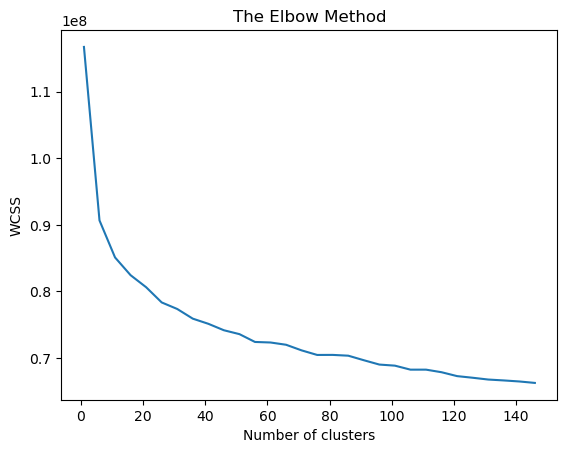

In [17]:
plt.plot(range(1, 150, 5), sse_scaled_distil1)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

###### V-measure

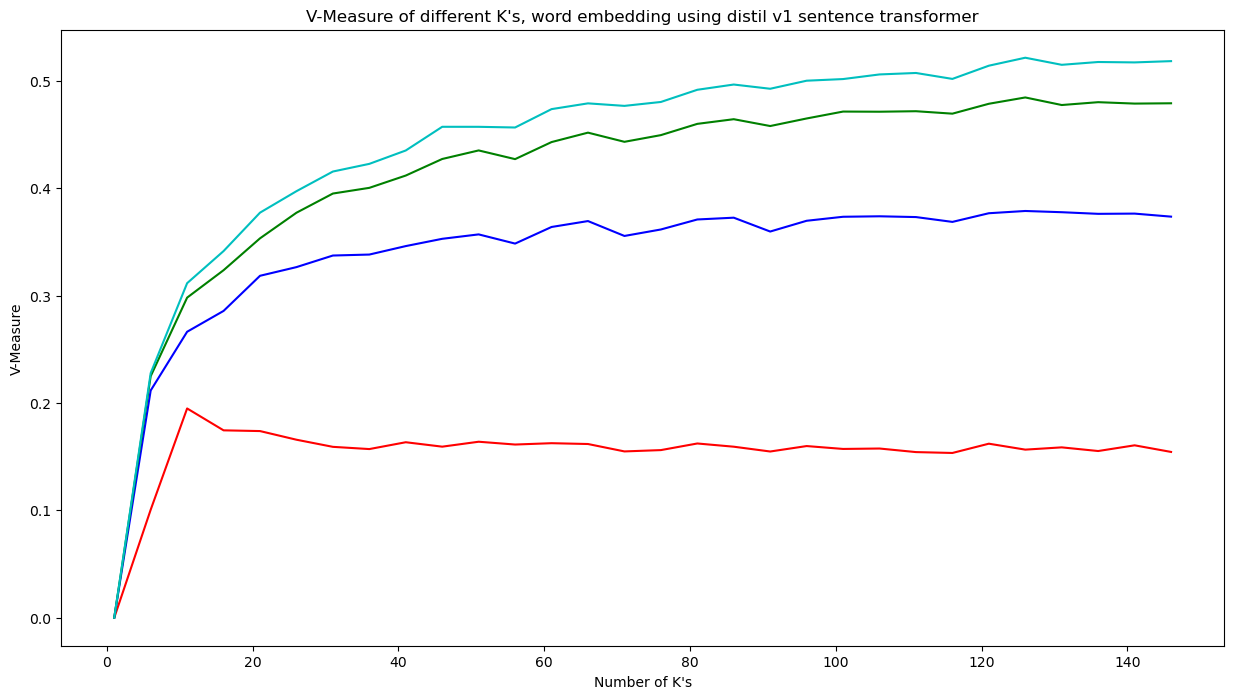

In [14]:
plot, ax = plt.subplots()
plt.plot(range(1, 150, 5), v_measures_df_distil_v1['layer_1'], 'r', range(1, 150, 5), v_measures_df_distil_v1['layer_2'], 'b', range(1, 150, 5), v_measures_df_distil_v1['layer_3'], 'g', range(1, 150, 5), v_measures_df_distil_v1['layer_4'], 'c')
plot.set_size_inches(15, 8)

ax.set_xlabel("Number of K's")
ax.set_ylabel("V-Measure")
ax.set_title("V-Measure of different K's, word embedding using distil v1 sentence transformer")

plt.show()

###### Homogeneity

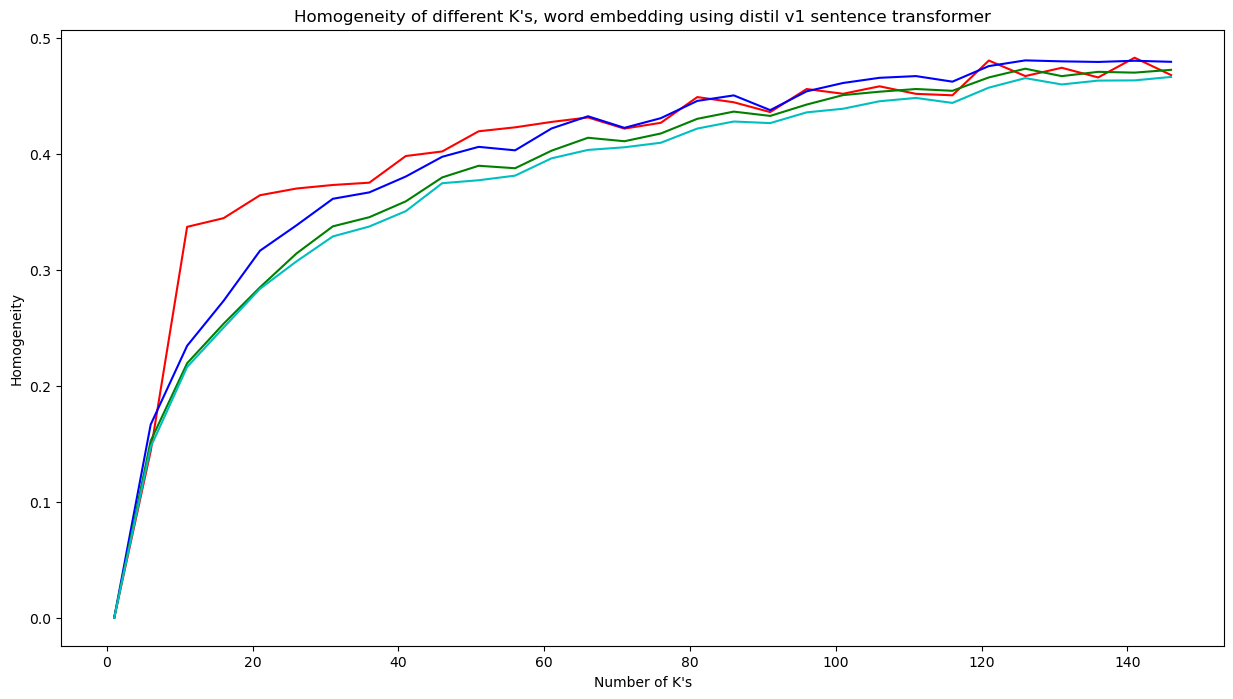

In [15]:
plot, ax = plt.subplots()
plt.plot(range(1, 150, 5), homogeneity_measures_df_distil_v1['layer_1'], 'r', range(1, 150, 5), homogeneity_measures_df_distil_v1['layer_2'], 'b', range(1, 150, 5), homogeneity_measures_df_distil_v1['layer_3'], 'g', range(1, 150, 5), homogeneity_measures_df_distil_v1['layer_4'], 'c')
plot.set_size_inches(15, 8)

ax.set_xlabel("Number of K's")
ax.set_ylabel("Homogeneity")
ax.set_title("Homogeneity of different K's, word embedding using distil v1 sentence transformer")

plt.show()

###### Completeness

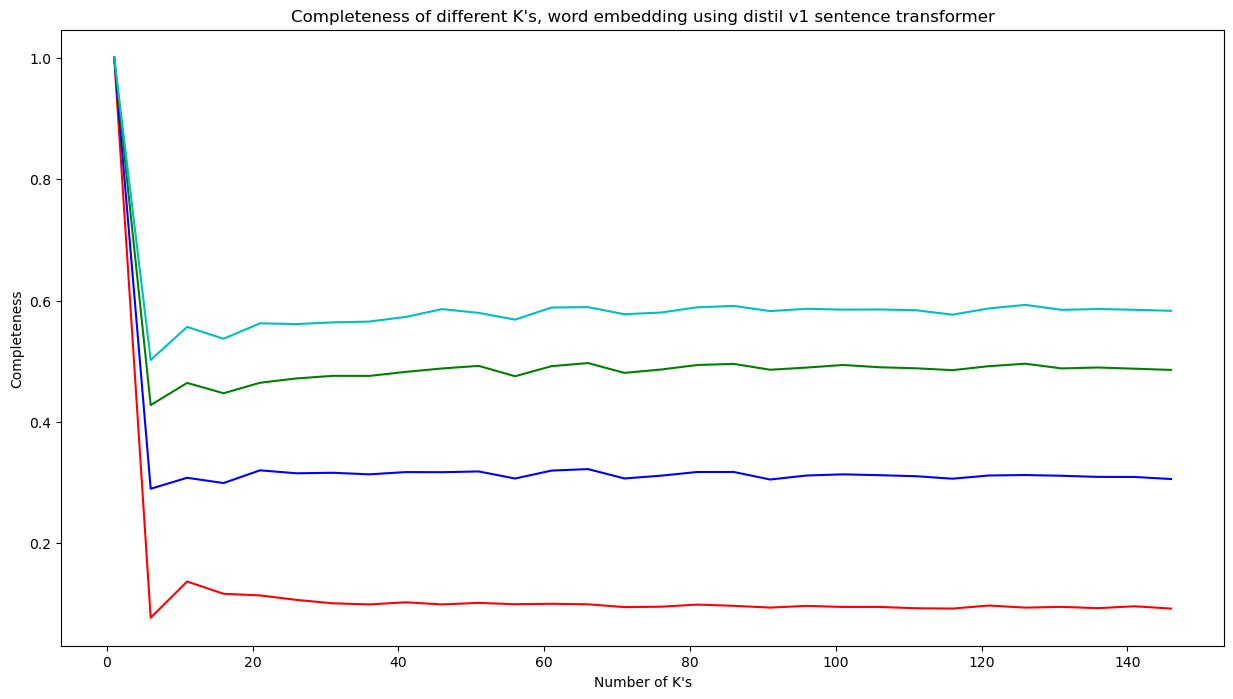

In [16]:
plot, ax = plt.subplots()
plt.plot(range(1, 150, 5), completness_measures_df_distil_v1['layer_1'], 'r', range(1, 150, 5), completness_measures_df_distil_v1['layer_2'], 'b', range(1, 150, 5), completness_measures_df_distil_v1['layer_3'], 'g', range(1, 150, 5), completness_measures_df_distil_v1['layer_4'], 'c')
plot.set_size_inches(15, 8)

ax.set_xlabel("Number of K's")
ax.set_ylabel("Completeness")
ax.set_title("Completeness of different K's, word embedding using distil v1 sentence transformer")

plt.show()

#### distil v2

In [10]:
X_train = sc_X.fit_transform(list(embedded_df_distil_v2))

# A list holds the SSE values for each k
sse_scaled_distil2 = []
v_measures = []
homogeneity_measures = []
completeness_measures = []

v_measures_df_distil_v2 = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])
homogeneity_measures_df_distil_v2 = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])
completness_measures_df_distil_v2 = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])

for k in range(1, 150, 5):
    print('\rProgress: %d' % k, end='')
    sys.stdout.flush()
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_train)
    sse_scaled_distil2.append(kmeans.inertia_)
    
    # calculating the v-measures for each of the subcategories/layers, and adding them to the v_measures_df dataframe
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_1'], kmeans.labels_))
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_2'], kmeans.labels_))
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_3'], kmeans.labels_))
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_4'], kmeans.labels_))

    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_1'], kmeans.labels_))
    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_2'], kmeans.labels_))
    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_3'], kmeans.labels_))
    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_4'], kmeans.labels_))

    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_1'], kmeans.labels_))
    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_2'], kmeans.labels_))
    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_3'], kmeans.labels_))
    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_4'], kmeans.labels_))


    v_measures_df_distil_v2.loc[len(v_measures_df_distil_v2)] = v_measures
    homogeneity_measures_df_distil_v2.loc[len(homogeneity_measures_df_distil_v2)] = homogeneity_measures
    completness_measures_df_distil_v2.loc[len(completness_measures_df_distil_v2)] = completeness_measures

    v_measures = []
    homogeneity_measures = []
    completeness_measures = []
    

Progress: 146

In [14]:
v_measures_df_distil_v2.to_csv('calculated_files/evaluation_metric_dfs/v_measures_df_distil_v2.csv', index=False)
homogeneity_measures_df_distil_v2.to_csv('calculated_files/evaluation_metric_dfs/homogeneity_measures_df_distil_v2.csv', index=False)
completness_measures_df_distil_v2.to_csv('calculated_files/evaluation_metric_dfs/completness_measures_df_distil_v2.csv', index=False)
np.save('calculated_files/sse/WE_distil2.npy', sse_scaled_distil2)
sse_scaled_distil2 = np.load('calculated_files/sse/WE_distil2.npy', allow_pickle=True)

##### Plot V2

Elbow

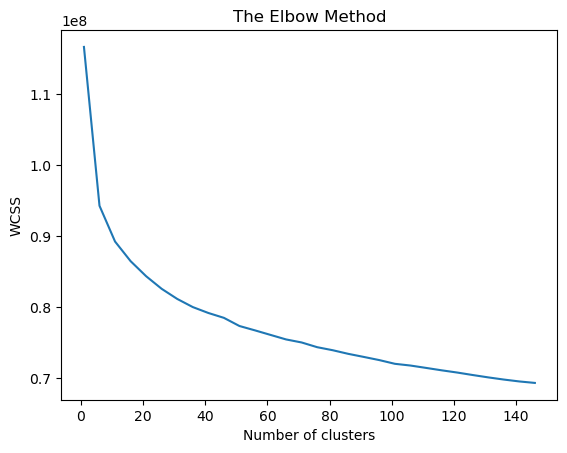

In [15]:
plt.plot(range(1, 150, 5), sse_scaled_distil2)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

###### V-measure

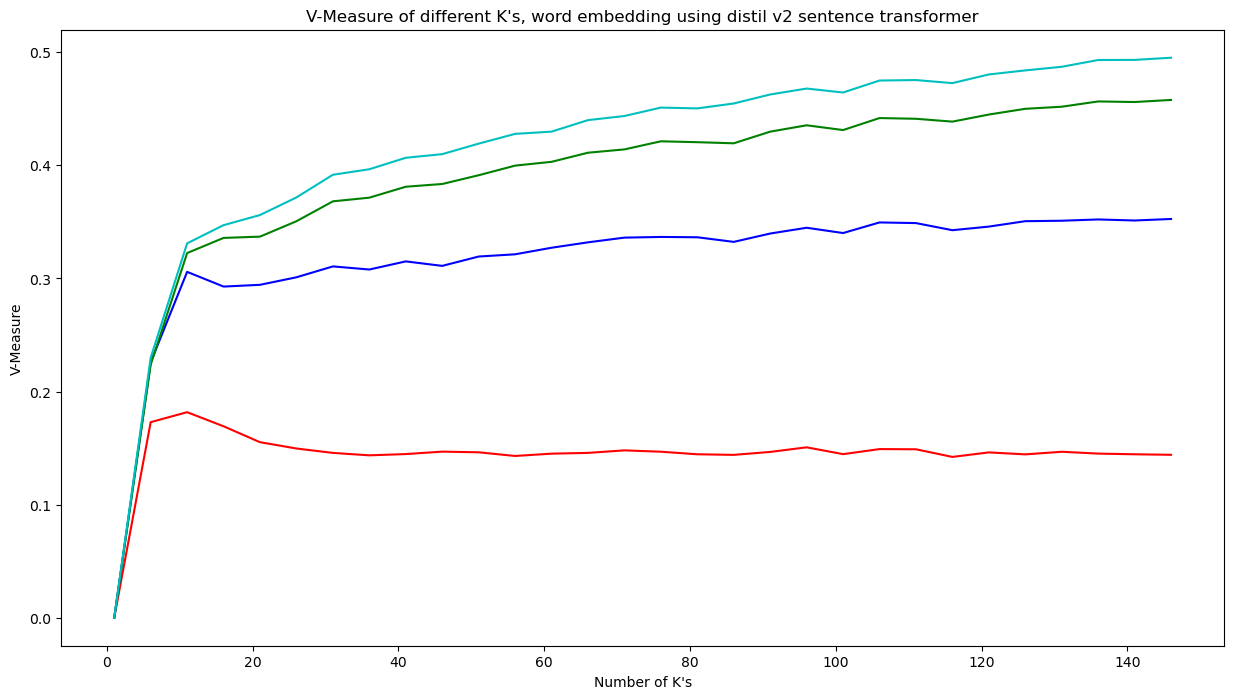

In [12]:
plot, ax = plt.subplots()
plt.plot(range(1, 150, 5), v_measures_df_distil_v2['layer_1'], 'r', range(1, 150, 5), v_measures_df_distil_v2['layer_2'], 'b', range(1, 150, 5), v_measures_df_distil_v2['layer_3'], 'g', range(1, 150, 5), v_measures_df_distil_v2['layer_4'], 'c')
plot.set_size_inches(15, 8)

ax.set_xlabel("Number of K's")
ax.set_ylabel("V-Measure")
ax.set_title("V-Measure of different K's, word embedding using distil v2 sentence transformer")

plt.show()

###### Homogeneity

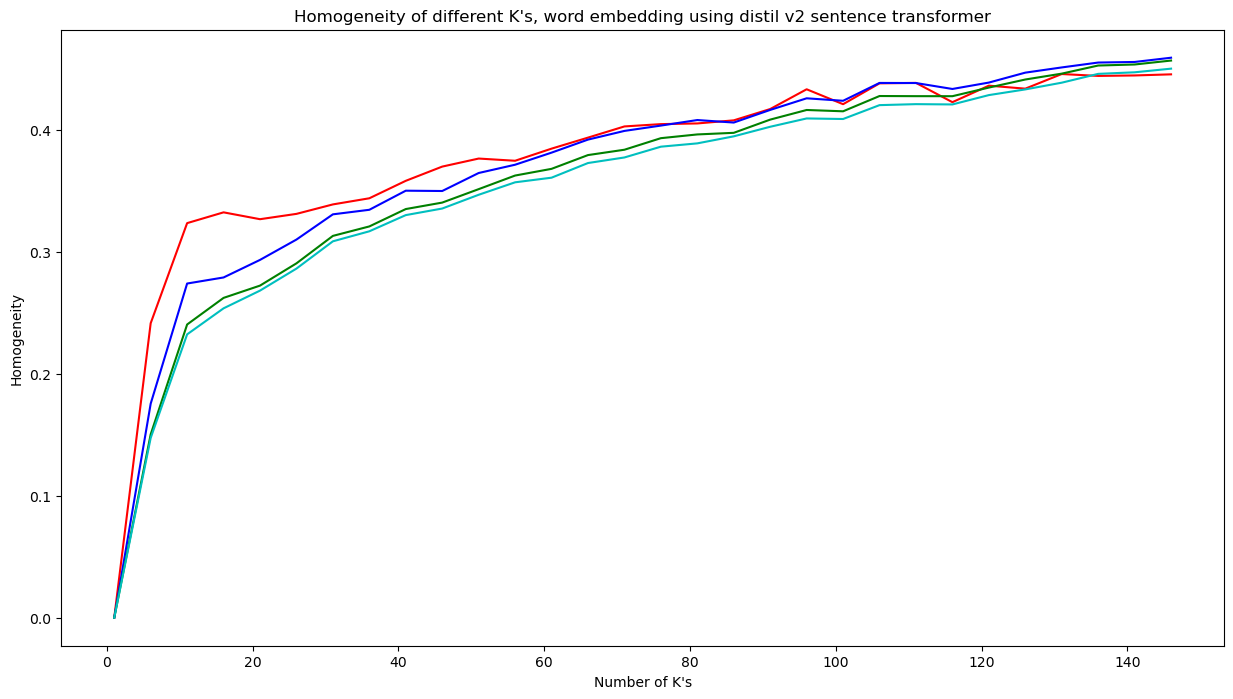

In [13]:
plot, ax = plt.subplots()
plt.plot(range(1, 150, 5), homogeneity_measures_df_distil_v2['layer_1'], 'r', range(1, 150, 5), homogeneity_measures_df_distil_v2['layer_2'], 'b', range(1, 150, 5), homogeneity_measures_df_distil_v2['layer_3'], 'g', range(1, 150, 5), homogeneity_measures_df_distil_v2['layer_4'], 'c')
plot.set_size_inches(15, 8)

ax.set_xlabel("Number of K's")
ax.set_ylabel("Homogeneity")
ax.set_title("Homogeneity of different K's, word embedding using distil v2 sentence transformer")

plt.show()

###### Completeness

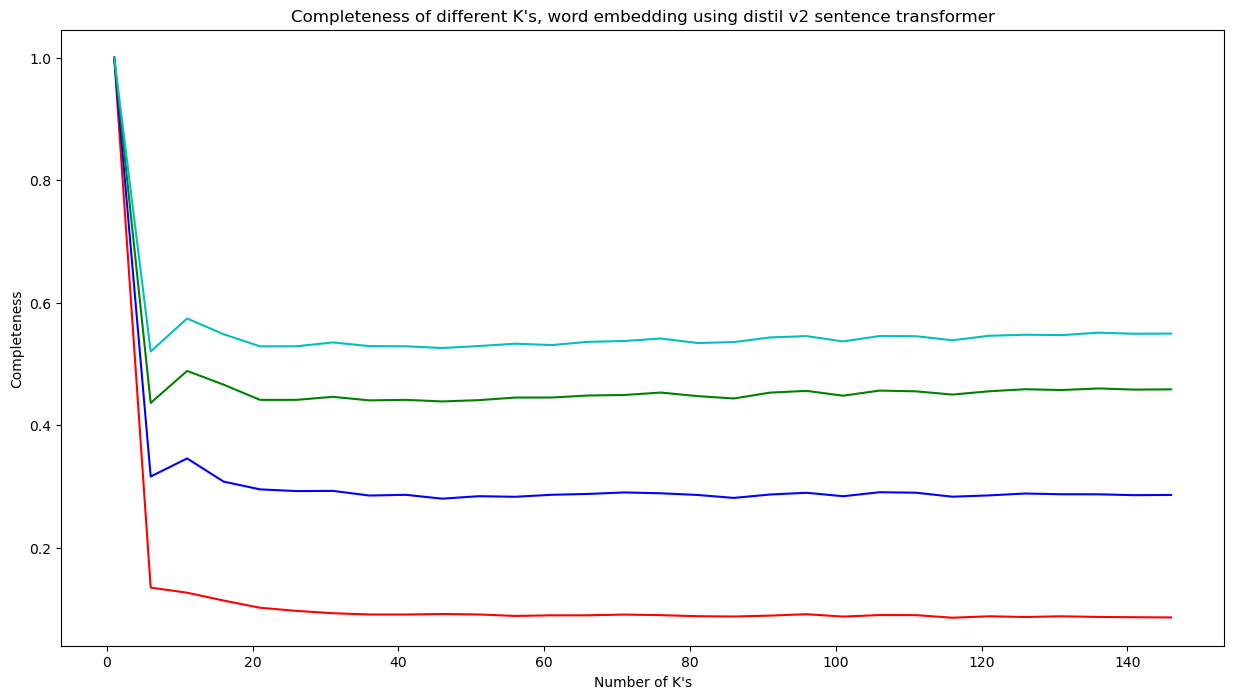

In [14]:
plot, ax = plt.subplots()
plt.plot(range(1, 150, 5), completness_measures_df_distil_v2['layer_1'], 'r', range(1, 150, 5), completness_measures_df_distil_v2['layer_2'], 'b', range(1, 150, 5), completness_measures_df_distil_v2['layer_3'], 'g', range(1, 150, 5), completness_measures_df_distil_v2['layer_4'], 'c')
plot.set_size_inches(15, 8)

ax.set_xlabel("Number of K's")
ax.set_ylabel("Completeness")
ax.set_title("Completeness of different K's, word embedding using distil v2 sentence transformer")

plt.show()

#### paraphrase miniLM

In [15]:
X_train = sc_X.fit_transform(list(embedded_df_paraph_miniLM))

# A list holds the SSE values for each k
sse_scaled_miniLM = []
v_measures = []
homogeneity_measures = []
completeness_measures = []

v_measures_df_paraph_miniLM = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])
homogeneity_measures_df_paraph_miniLM = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])
completness_measures_df_paraph_miniLM = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])

for k in range(1, 150, 5):
    print('\rProgress: %d' % k, end='')
    sys.stdout.flush()
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_train)
    sse_scaled_miniLM.append(kmeans.inertia_)
    
    # calculating the v-measures for each of the subcategories/layers, and adding them to the v_measures_df dataframe
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_1'], kmeans.labels_))
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_2'], kmeans.labels_))
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_3'], kmeans.labels_))
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_4'], kmeans.labels_))

    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_1'], kmeans.labels_))
    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_2'], kmeans.labels_))
    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_3'], kmeans.labels_))
    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_4'], kmeans.labels_))

    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_1'], kmeans.labels_))
    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_2'], kmeans.labels_))
    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_3'], kmeans.labels_))
    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_4'], kmeans.labels_))


    v_measures_df_paraph_miniLM.loc[len(v_measures_df_paraph_miniLM)] = v_measures
    homogeneity_measures_df_paraph_miniLM.loc[len(homogeneity_measures_df_paraph_miniLM)] = homogeneity_measures
    completness_measures_df_paraph_miniLM.loc[len(completness_measures_df_paraph_miniLM)] = completeness_measures

    v_measures = []
    homogeneity_measures = []
    completeness_measures = []


Progress: 146

In [18]:
v_measures_df_paraph_miniLM.to_csv('calculated_files/evaluation_metric_dfs/v_measures_df_paraph_miniLM.csv', index=False)
homogeneity_measures_df_paraph_miniLM.to_csv('calculated_files/evaluation_metric_dfs/homogeneity_measures_df_paraph_miniLM.csv', index=False)
completness_measures_df_paraph_miniLM.to_csv('calculated_files/evaluation_metric_dfs/completness_measures_df_paraph_miniLM.csv', index=False)

np.save('calculated_files/sse/WE_miniLM.npy', sse_scaled_miniLM)
sse_scaled_miniLM = np.load('calculated_files/sse/WE_miniLM.npy', allow_pickle=True)

##### Plot miniLM

Elbow

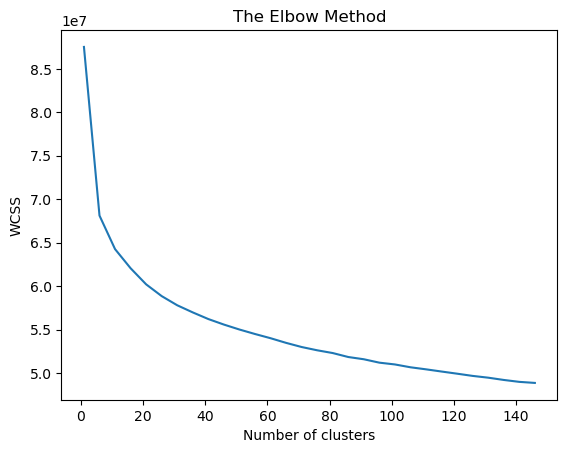

In [19]:
plt.plot(range(1, 150, 5), sse_scaled_miniLM)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

###### V-measure

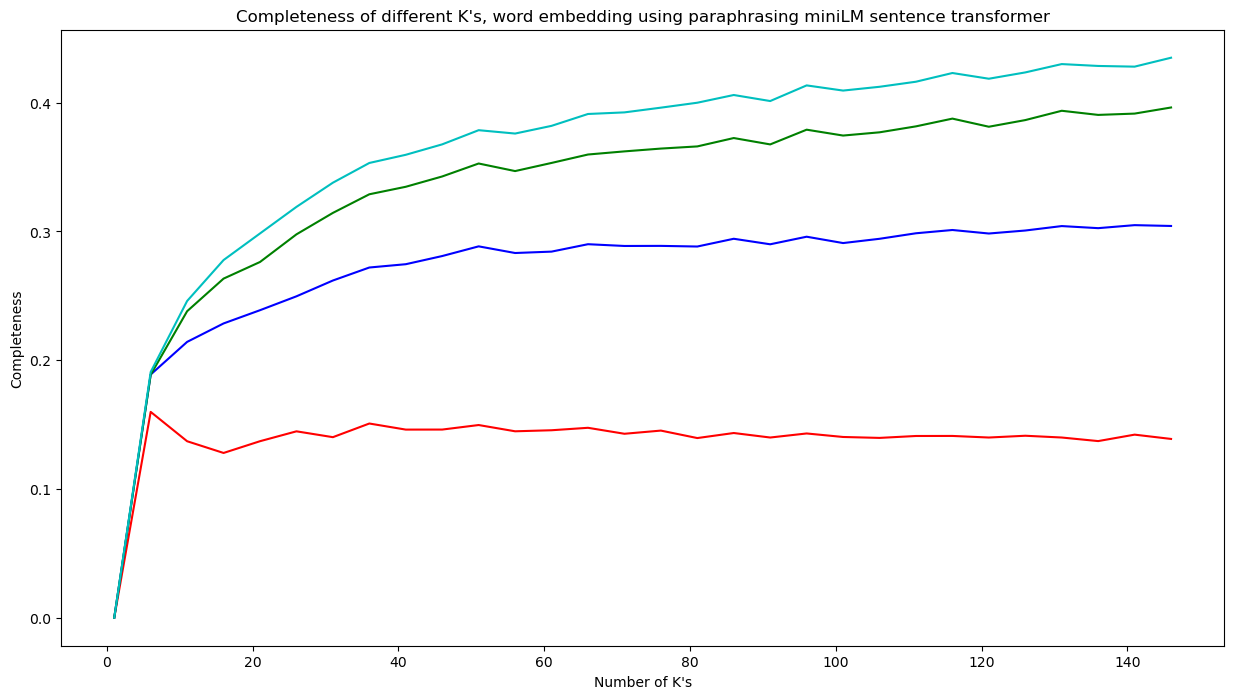

In [17]:
plot, ax = plt.subplots()
plt.plot(range(1, 150, 5), v_measures_df_paraph_miniLM['layer_1'], 'r', range(1, 150, 5), v_measures_df_paraph_miniLM['layer_2'], 'b', range(1, 150, 5), v_measures_df_paraph_miniLM['layer_3'], 'g', range(1, 150, 5), v_measures_df_paraph_miniLM['layer_4'], 'c')
plot.set_size_inches(15, 8)

ax.set_xlabel("Number of K's")
ax.set_ylabel("Completeness")
ax.set_title("Completeness of different K's, word embedding using paraphrasing miniLM sentence transformer")

plt.show()

###### Homogeneity

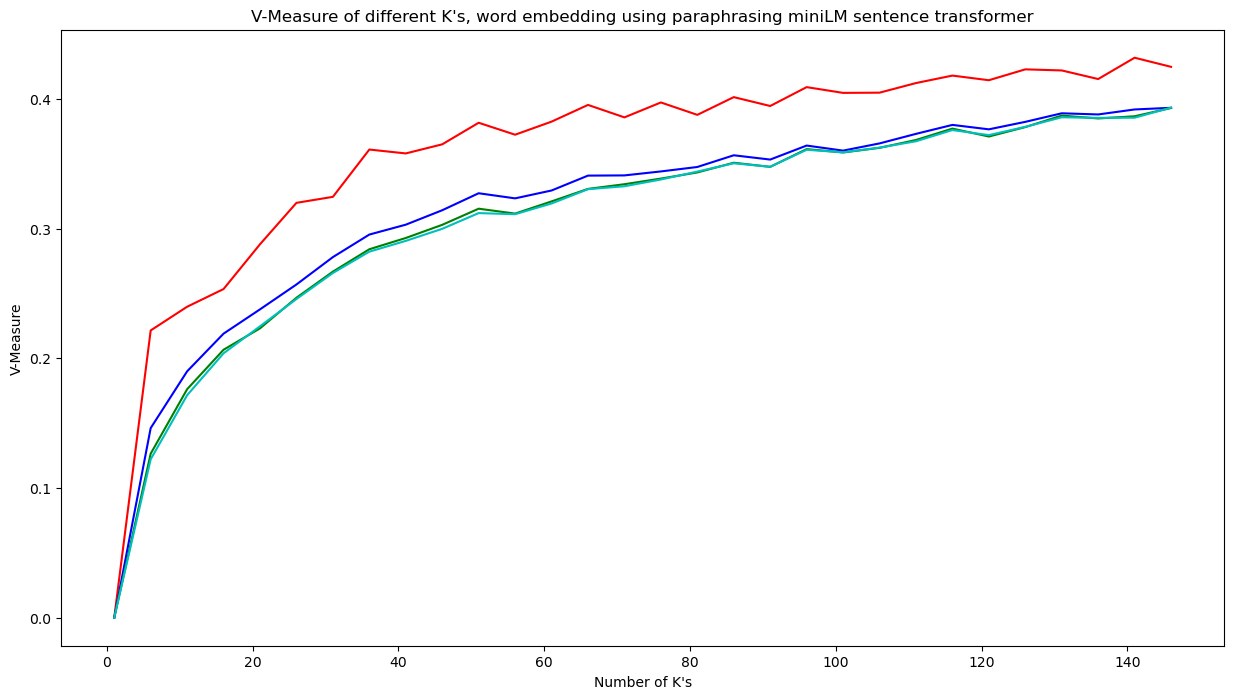

In [18]:
plot, ax = plt.subplots()
plt.plot(range(1, 150, 5), homogeneity_measures_df_paraph_miniLM['layer_1'], 'r', range(1, 150, 5), homogeneity_measures_df_paraph_miniLM['layer_2'], 'b', range(1, 150, 5), homogeneity_measures_df_paraph_miniLM['layer_3'], 'g', range(1, 150, 5), homogeneity_measures_df_paraph_miniLM['layer_4'], 'c')
plot.set_size_inches(15, 8)

ax.set_xlabel("Number of K's")
ax.set_ylabel("V-Measure")
ax.set_title("V-Measure of different K's, word embedding using paraphrasing miniLM sentence transformer")
plt.show()


###### Completeness

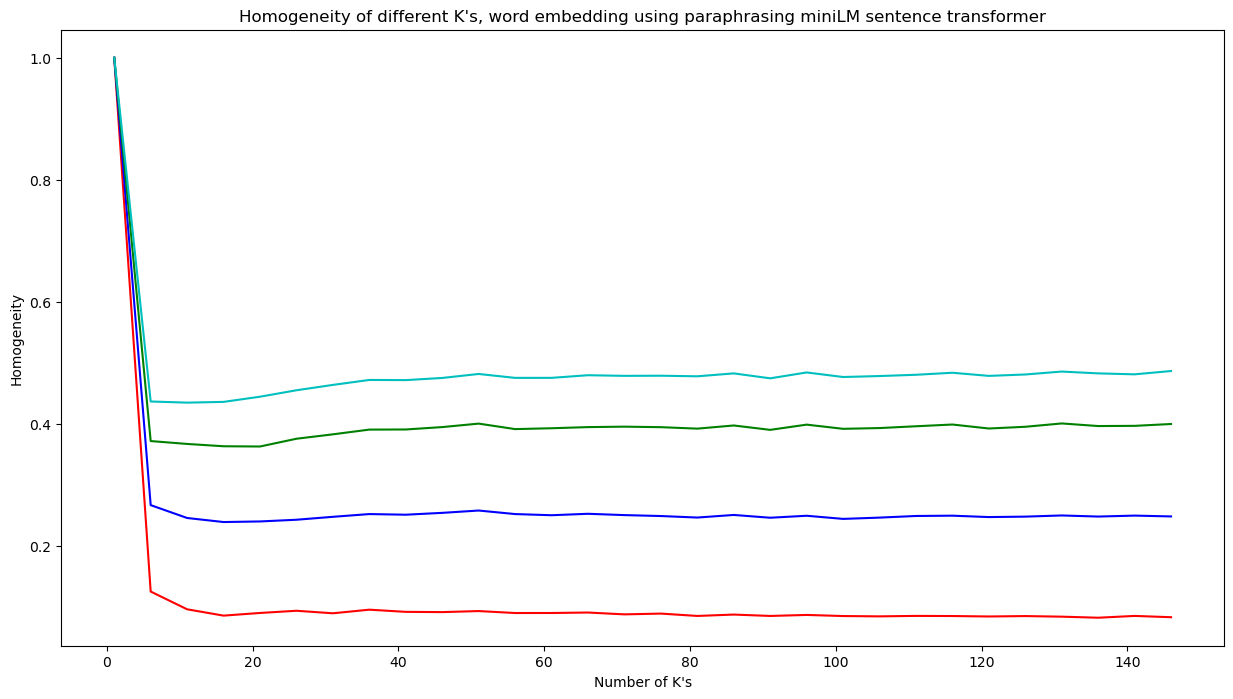

In [19]:
plot, ax = plt.subplots()
plt.plot(range(1, 150, 5), completness_measures_df_paraph_miniLM['layer_1'], 'r', range(1, 150, 5), completness_measures_df_paraph_miniLM['layer_2'], 'b', range(1, 150, 5), completness_measures_df_paraph_miniLM['layer_3'], 'g', range(1, 150, 5), completness_measures_df_paraph_miniLM['layer_4'], 'c')
plot.set_size_inches(15, 8)

ax.set_xlabel("Number of K's")
ax.set_ylabel("Homogeneity")
ax.set_title("Homogeneity of different K's, word embedding using paraphrasing miniLM sentence transformer")

plt.show()

#### paraphrase mpnet

In [9]:
X_train = sc_X.fit_transform(list(embedded_df_paraph_mpnet))

# A list holds the SSE values for each k
sse_scaled_mpnet = []
v_measures = []
homogeneity_measures = []
completeness_measures = []

v_measures_df_paraph_mpnet = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])
homogeneity_measures_df_paraph_mpnet = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])
completness_measures_df_paraph_mpnet = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])

for k in range(1, 150, 5):
    print('\rProgress: %d' % k, end='')
    sys.stdout.flush()
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs) #todo: minibatch kmeans
    kmeans.fit(X_train)
    sse_scaled_mpnet.append(kmeans.inertia_)
    
    # calculating the v-measures for each of the subcategories/layers, and adding them to the v_measures_df dataframe
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_1'], kmeans.labels_))
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_2'], kmeans.labels_))
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_3'], kmeans.labels_))
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_4'], kmeans.labels_))

    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_1'], kmeans.labels_))
    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_2'], kmeans.labels_))
    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_3'], kmeans.labels_))
    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_4'], kmeans.labels_))

    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_1'], kmeans.labels_))
    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_2'], kmeans.labels_))
    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_3'], kmeans.labels_))
    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_4'], kmeans.labels_))


    v_measures_df_paraph_mpnet.loc[len(v_measures_df_paraph_mpnet)] = v_measures
    homogeneity_measures_df_paraph_mpnet.loc[len(homogeneity_measures_df_paraph_mpnet)] = homogeneity_measures
    completness_measures_df_paraph_mpnet.loc[len(completness_measures_df_paraph_mpnet)] = completeness_measures

    v_measures = []
    homogeneity_measures = []
    completeness_measures = []
    

Progress: 146

In [10]:
v_measures_df_paraph_mpnet.to_csv('calculated_files/evaluation_metric_dfs/v_measures_df_paraph_mpnet.csv', index=False)
homogeneity_measures_df_paraph_mpnet.to_csv('calculated_files/evaluation_metric_dfs/homogeneity_measures_df_paraph_mpnet.csv', index=False)
completness_measures_df_paraph_mpnet.to_csv('calculated_files/evaluation_metric_dfs/completness_measures_df_paraph_mpnet.csv', index=False)
np.save('calculated_files/sse/WE_mpnet.npy', sse_scaled_mpnet)
sse_scaled_mpnet = np.load('calculated_files/sse/WE_mpnet.npy', allow_pickle=True)

##### Plot mpnet

Elbow

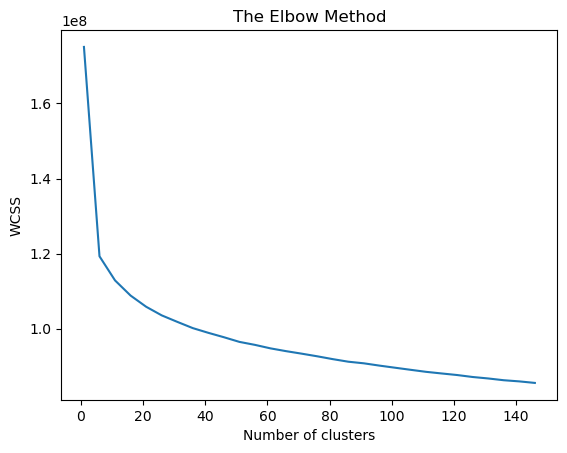

In [20]:
plt.plot(range(1, 150, 5), sse_scaled_mpnet)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

###### V-measure

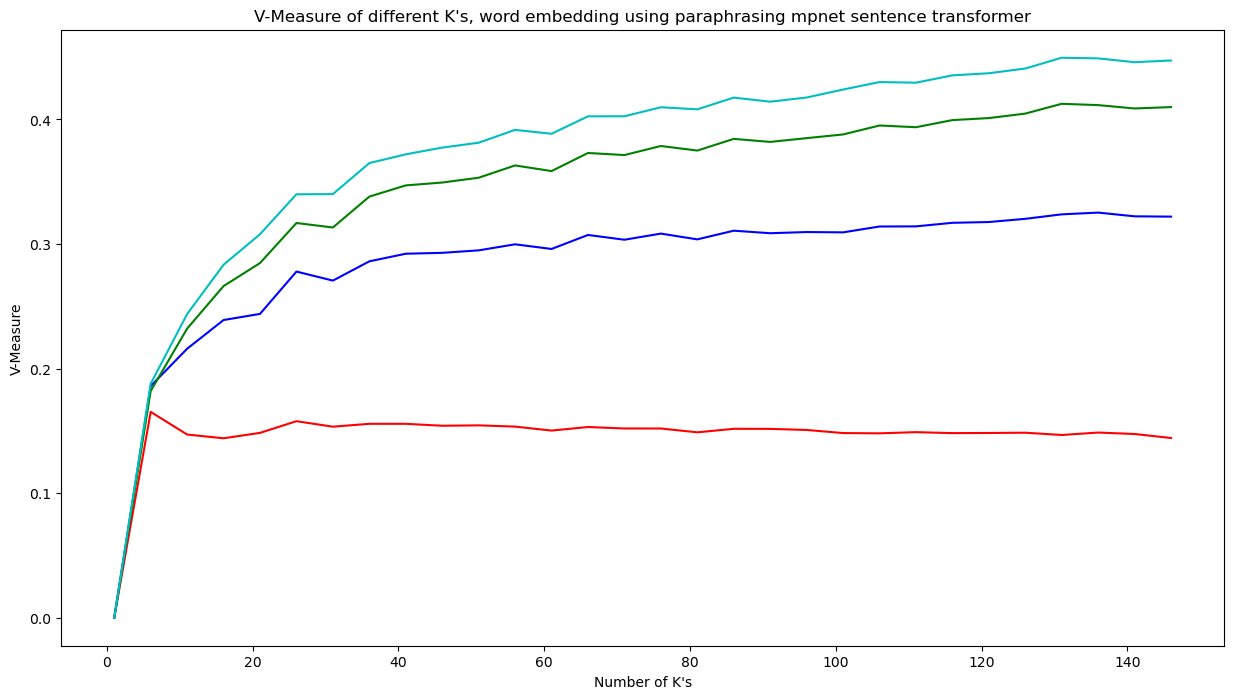

In [11]:
plot, ax = plt.subplots()
plt.plot(range(1, 150, 5), v_measures_df_paraph_mpnet['layer_1'], 'r', range(1, 150, 5), v_measures_df_paraph_mpnet['layer_2'], 'b', range(1, 150, 5), v_measures_df_paraph_mpnet['layer_3'], 'g', range(1, 150, 5), v_measures_df_paraph_mpnet['layer_4'], 'c')
plot.set_size_inches(15, 8)

ax.set_xlabel("Number of K's")
ax.set_ylabel("V-Measure")
ax.set_title("V-Measure of different K's, word embedding using paraphrasing mpnet sentence transformer")

plt.show()

###### Homogeneity

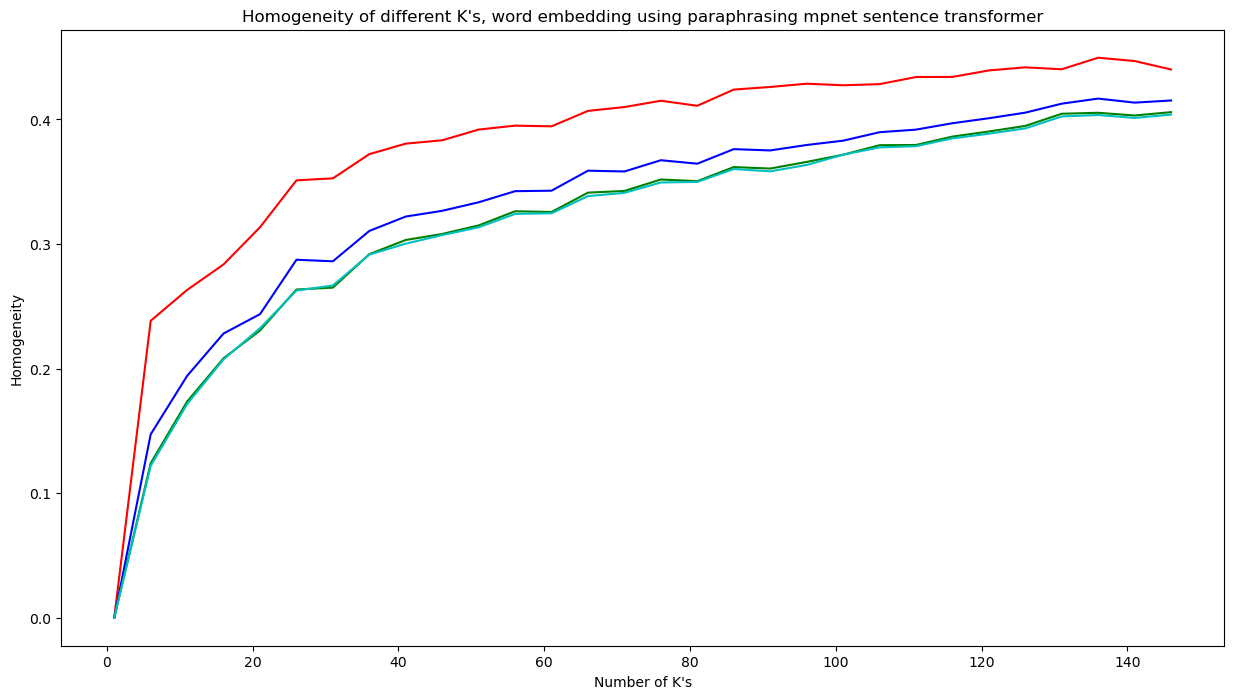

In [12]:
plot, ax = plt.subplots()
plt.plot(range(1, 150, 5), homogeneity_measures_df_paraph_mpnet['layer_1'], 'r', range(1, 150, 5), homogeneity_measures_df_paraph_mpnet['layer_2'], 'b', range(1, 150, 5), homogeneity_measures_df_paraph_mpnet['layer_3'], 'g', range(1, 150, 5), homogeneity_measures_df_paraph_mpnet['layer_4'], 'c')
plot.set_size_inches(15, 8)

ax.set_xlabel("Number of K's")
ax.set_ylabel("Homogeneity")
ax.set_title("Homogeneity of different K's, word embedding using paraphrasing mpnet sentence transformer")

plt.show()

###### Completeness

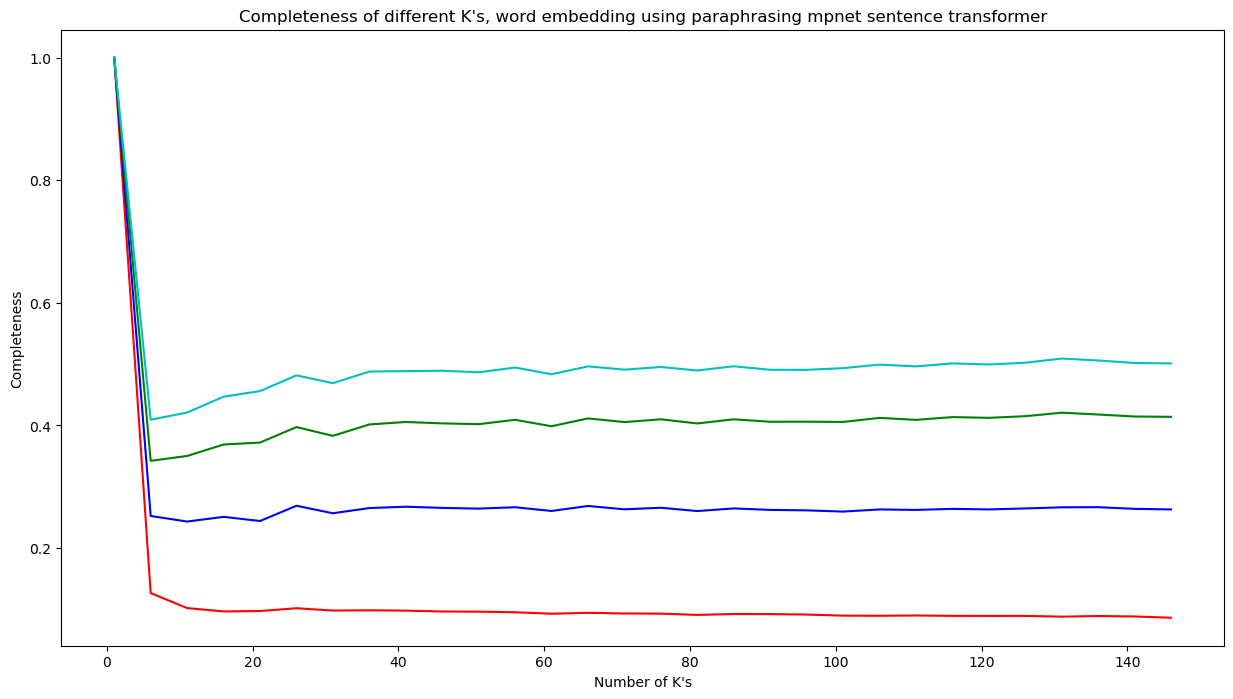

In [13]:
plot, ax = plt.subplots()
plt.plot(range(1, 150, 5), completness_measures_df_paraph_mpnet['layer_1'], 'r', range(1, 150, 5), completness_measures_df_paraph_mpnet['layer_2'], 'b', range(1, 150, 5), completness_measures_df_paraph_mpnet['layer_3'], 'g', range(1, 150, 5), completness_measures_df_paraph_mpnet['layer_4'], 'c')
plot.set_size_inches(15, 8)

ax.set_xlabel("Number of K's")
ax.set_ylabel("Completeness")
ax.set_title("Completeness of different K's, word embedding using paraphrasing mpnet sentence transformer")

plt.show()

### HDBSCAN

#### Distil V1

In [16]:
# len(embedded_df_distil_v1)
# eddv1, eddv2 = embedded_df_distil_v1[0:114000], embedded_df_distil_v1[114000:]  
# eddv1 = embedded_df_distil_v1[0:1000]

# len(embedded_df_distil_v2)
# len(embedded_df_paraph_miniLM)
len(embedded_df_paraph_mpnet)

227910

In [9]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(list(embedded_df_distil_v1))

clusterer = HDBSCAN(min_cluster_size=10, n_jobs=8, cluster_selection_epsilon=0.5)

In [10]:
v_measures_df_paraph_distil1 = pd.read_csv('calculated_files/evaluation_metric_dfs/v_measures_dbscan_distil1.csv')
homogeneity_measures_df_paraph_distil1 = pd.read_csv('calculated_files/evaluation_metric_dfs/homogene\ity_measures_dbscan_distil1.csv')
completness_measures_df_paraph_distil1 = pd.read_csv('calculated_files/evaluation_metric_dfs/completeness_measures_dbscan_distil1.csv')

In [18]:
homogeneity_measures_df_paraph_distil1

,layer_1,layer_2,layer_3,layer_4
0,0.536485,0.524689,0.513369,0.504388
1,0.332548,0.354596,0.354857,0.352730


In [19]:
# @jit(target_backend='cuda')

cluster_labels = clusterer.fit_predict(X_train)

v_measures = []
homogeneity_measures = []
completeness_measures = []

# calculating the v-measures for each of the subcategories/layers, and adding them to the v_measures_df dataframe
v_measures.append(v_measure_score(layered_descriptions_filtered['layer_1'], cluster_labels))
v_measures.append(v_measure_score(layered_descriptions_filtered['layer_2'], cluster_labels))
v_measures.append(v_measure_score(layered_descriptions_filtered['layer_3'], cluster_labels))
v_measures.append(v_measure_score(layered_descriptions_filtered['layer_4'], cluster_labels))

homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_1'], cluster_labels))
homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_2'], cluster_labels))
homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_3'], cluster_labels))
homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_4'], cluster_labels))

completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_1'], cluster_labels))
completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_2'], cluster_labels))
completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_3'], cluster_labels))
completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_4'], cluster_labels))


v_measures_df_paraph_distil1.loc[len(v_measures_df_paraph_distil1)] = v_measures
homogeneity_measures_df_paraph_distil1.loc[len(homogeneity_measures_df_paraph_distil1)] = homogeneity_measures
completness_measures_df_paraph_distil1.loc[len(completness_measures_df_paraph_distil1)] = completeness_measures

v_measures = []
homogeneity_measures = []
completeness_measures = []

v_measures_df_paraph_distil1.to_csv('calculated_files/evaluation_metric_dfs/v_measures_dbscan_distil1.csv', index=False)
homogeneity_measures_df_paraph_distil1.to_csv('calculated_files/evaluation_metric_dfs/homogene\ity_measures_dbscan_distil1.csv', index=False)
completness_measures_df_paraph_distil1.to_csv('calculated_files/evaluation_metric_dfs/completeness_measures_dbscan_distil1.csv', index=False)

v_measures_df_paraph_distil1 = pd.read_csv('calculated_files/evaluation_metric_dfs/v_measures_dbscan_distil1.csv')
homogeneity_measures_df_paraph_distil1 = pd.read_csv('calculated_files/evaluation_metric_dfs/homogene\ity_measures_dbscan_distil1.csv')
completness_measures_df_paraph_distil1 = pd.read_csv('calculated_files/evaluation_metric_dfs/completeness_measures_dbscan_distil1.csv')



In [56]:
v_measures = []
homogeneity_measures = []
completeness_measures = []

v_measures_df_paraph_distil1 = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])
homogeneity_measures_df_paraph_distil1 = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])
completness_measures_df_paraph_distil1 = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])

In [21]:
completness_measures_df_paraph_distil1

,layer_1,layer_2,layer_3,layer_4
0,0.102527,0.323907,0.510584,0.610193
1,0.080731,0.278072,0.448328,0.542063
2,0.080731,0.278072,0.448328,0.542063


In [58]:
# calculating the v-measures for each of the subcategories/layers, and adding them to the v_measures_df dataframe
v_measures.append(v_measure_score(layered_descriptions_filtered['layer_1'], cluster_labels))
v_measures.append(v_measure_score(layered_descriptions_filtered['layer_2'], cluster_labels))
v_measures.append(v_measure_score(layered_descriptions_filtered['layer_3'], cluster_labels))
v_measures.append(v_measure_score(layered_descriptions_filtered['layer_4'], cluster_labels))

homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_1'], cluster_labels))
homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_2'], cluster_labels))
homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_3'], cluster_labels))
homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_4'], cluster_labels))

completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_1'], cluster_labels))
completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_2'], cluster_labels))
completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_3'], cluster_labels))
completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_4'], cluster_labels))


v_measures_df_paraph_distil1.loc[len(v_measures_df_paraph_distil1)] = v_measures
homogeneity_measures_df_paraph_distil1.loc[len(homogeneity_measures_df_paraph_distil1)] = homogeneity_measures
completness_measures_df_paraph_distil1.loc[len(completness_measures_df_paraph_distil1)] = completeness_measures

v_measures = []
homogeneity_measures = []
completeness_measures = []

v_measures_df_paraph_distil1.to_csv('calculated_files/evaluation_metric_dfs/v_measures_dbscan_distil1.csv', index=False)
homogeneity_measures_df_paraph_distil1.to_csv('calculated_files/evaluation_metric_dfs/homogene\ity_measures_dbscan_distil1.csv', index=False)
completness_measures_df_paraph_distil1.to_csv('calculated_files/evaluation_metric_dfs/completeness_measures_dbscan_distil1.csv', index=False)

v_measures_df_paraph_distil1 = pd.read_csv('calculated_files/evaluation_metric_dfs/v_measures_dbscan_distil1.csv')
homogeneity_measures_df_paraph_distil1 = pd.read_csv('calculated_files/evaluation_metric_dfs/homogene\ity_measures_dbscan_distil1.csv')
completness_measures_df_paraph_distil1 = pd.read_csv('calculated_files/evaluation_metric_dfs/completeness_measures_dbscan_distil1.csv')


In [ ]:
# np.save('/home/jovyan/calculated_files/hdbscan/lblcluster_distil_v12.npy', cluster_labels)
# np.save('/home/jovyan/calculated_files/hdbscan/lblcluster_distil_v12_ep_0.1.npy', cluster_labels)
# joblib.dump(clusterer, 'hdbscan_model_ep_0.1.joblib') # the model
np.save('/home/jovyan/calculated_files/hdbscan/lblcluster_distil_v12_ep_0.5.npy', cluster_labels)
joblib.dump(clusterer, 'hdbscan_model_ep_0.5.joblib') # the model

# lblcluster_distil_v1 = np.load('calculated_files/hdbscan/lblcluster_distil_v1.npy', allow_pickle=True) 

# loaded_clusterer = joblib.load('hdbscan_model_ep_0.1.joblib')

['hdbscan_model_ep_0.1.joblib']

In [ ]:
alist = [lblcluster_distil_v1, lblcluster_distil_v1]

number of clusters

In [40]:
unique_labels = np.unique(lblcluster_distil_v1)
num_clusters = len(unique_labels[unique_labels != -1])

print("Number of Clusters:", num_clusters)

Number of Clusters: 3687


##### V-measure

In [19]:
print(v_measure_score(layered_descriptions_filtered['layer_1'], lblcluster_distil_v1))
print(v_measure_score(layered_descriptions_filtered['layer_2'], lblcluster_distil_v1))
print(v_measure_score(layered_descriptions_filtered['layer_3'], lblcluster_distil_v1))
print(v_measure_score(layered_descriptions_filtered['layer_4'], lblcluster_distil_v1))

0.1721538868752207
0.4005450522555229
0.5119729015573955
0.5522681038470589


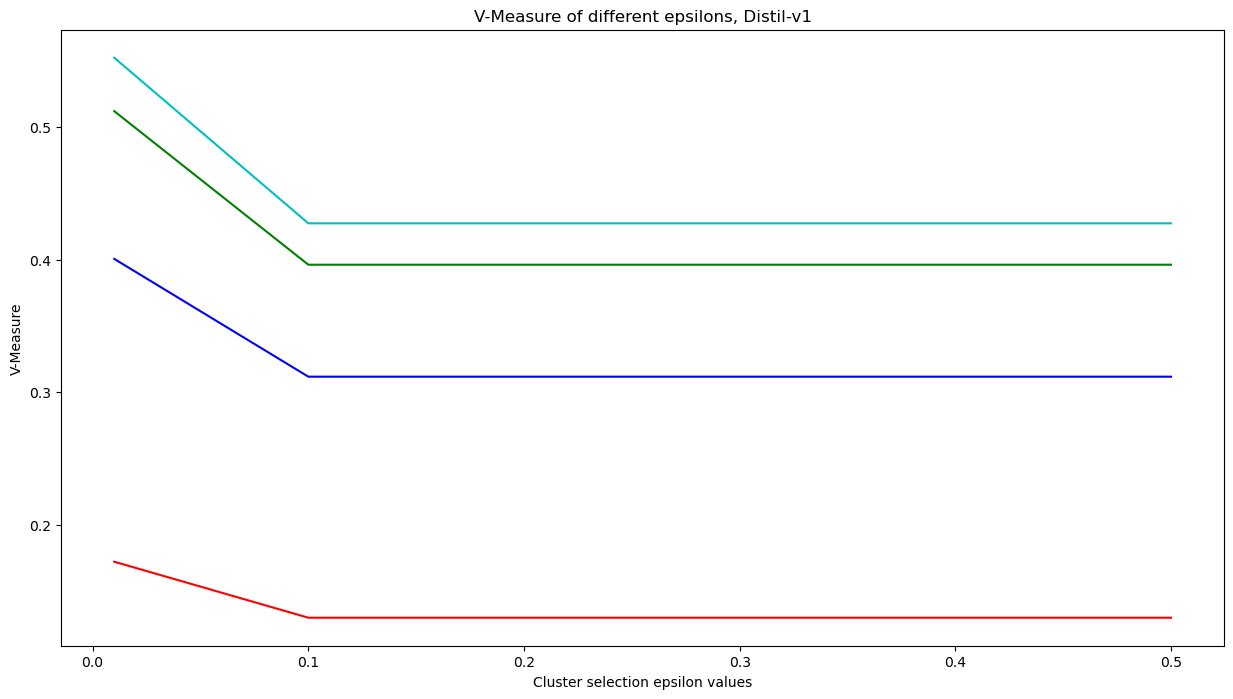

In [22]:
x_values = [0.01, 0.1, 0.5]

plot, ax = plt.subplots()
plt.plot(x_values,v_measures_df_paraph_distil1['layer_1'], 'r',
         x_values,v_measures_df_paraph_distil1['layer_2'], 'b',
         x_values,v_measures_df_paraph_distil1['layer_3'], 'g',
         x_values,v_measures_df_paraph_distil1['layer_4'], 'c')
plot.set_size_inches(15, 8)

ax.set_xlabel("Cluster selection epsilon values")
ax.set_ylabel("V-Measure")
ax.set_title("V-Measure of different epsilons, Distil-v1")

plt.show()

##### Homogeneity

In [23]:
print(homogeneity_score(layered_descriptions_filtered['layer_1'], lblcluster_distil_v1))
print(homogeneity_score(layered_descriptions_filtered['layer_2'], lblcluster_distil_v1))
print(homogeneity_score(layered_descriptions_filtered['layer_3'], lblcluster_distil_v1))
print(homogeneity_score(layered_descriptions_filtered['layer_4'], lblcluster_distil_v1))

NameError: name 'lblcluster_distil_v1' is not defined

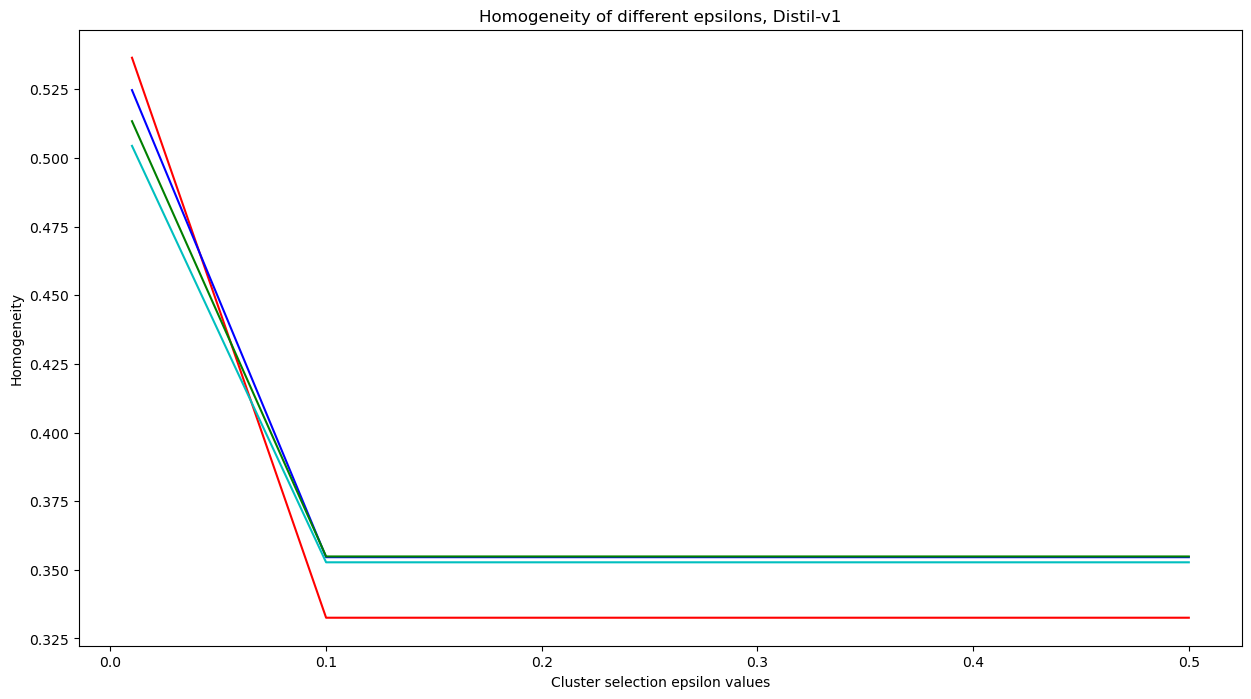

In [24]:
x_values = [0.01, 0.1, 0.5]

plot, ax = plt.subplots()
plt.plot(x_values,homogeneity_measures_df_paraph_distil1['layer_1'], 'r',
         x_values,homogeneity_measures_df_paraph_distil1['layer_2'], 'b',
         x_values,homogeneity_measures_df_paraph_distil1['layer_3'], 'g',
         x_values,homogeneity_measures_df_paraph_distil1['layer_4'], 'c')
plot.set_size_inches(15, 8)

ax.set_xlabel("Cluster selection epsilon values")
ax.set_ylabel("Homogeneity")
ax.set_title("Homogeneity of different epsilons, Distil-v1")

plt.show()

##### Completeness

In [21]:
print(completeness_score(layered_descriptions_filtered['layer_1'], lblcluster_distil_v1))
print(completeness_score(layered_descriptions_filtered['layer_2'], lblcluster_distil_v1))
print(completeness_score(layered_descriptions_filtered['layer_3'], lblcluster_distil_v1))
print(completeness_score(layered_descriptions_filtered['layer_4'], lblcluster_distil_v1))

0.10252699194666634
0.32390726104114875
0.5105839574465688
0.6101925167724868


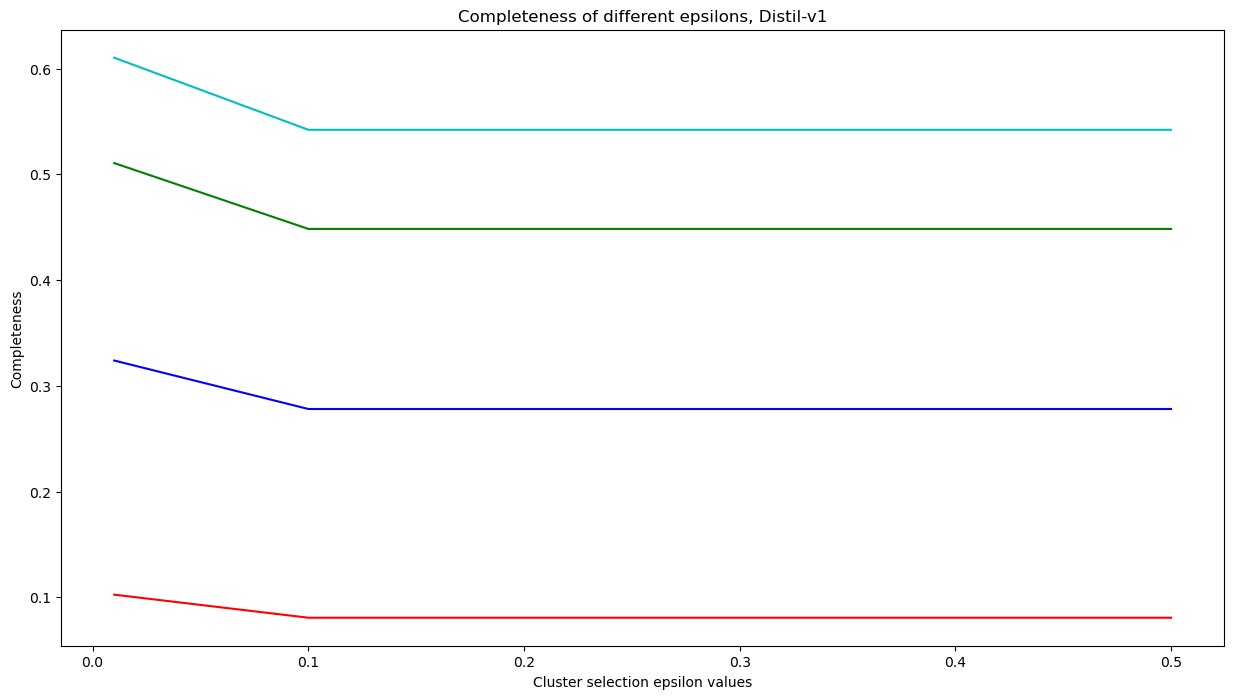

In [25]:
x_values = [0.01, 0.1, 0.5]

plot, ax = plt.subplots()
plt.plot(x_values,completness_measures_df_paraph_distil1['layer_1'], 'r',
         x_values,completness_measures_df_paraph_distil1['layer_2'], 'b',
         x_values,completness_measures_df_paraph_distil1['layer_3'], 'g',
         x_values,completness_measures_df_paraph_distil1['layer_4'], 'c')
plot.set_size_inches(15, 8)

ax.set_xlabel("Cluster selection epsilon values")
ax.set_ylabel("Completeness")
ax.set_title("Completeness of different epsilons, Distil-v1")

plt.show()

#### Distil v2

In [26]:
v_measures = []
homogeneity_measures = []
completeness_measures = []

v_measures_df_paraph_distil2 = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])
homogeneity_measures_df_paraph_distil2 = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])
completness_measures_df_paraph_distil2 = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])

In [28]:
# calculating the v-measures for each of the subcategories/layers, and adding them to the v_measures_df dataframe
v_measures.append(v_measure_score(layered_descriptions_filtered['layer_1'], cluster_labels_distil2))
v_measures.append(v_measure_score(layered_descriptions_filtered['layer_2'], cluster_labels_distil2))
v_measures.append(v_measure_score(layered_descriptions_filtered['layer_3'], cluster_labels_distil2))
v_measures.append(v_measure_score(layered_descriptions_filtered['layer_4'], cluster_labels_distil2))

homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_1'], cluster_labels_distil2))
homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_2'], cluster_labels_distil2))
homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_3'], cluster_labels_distil2))
homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_4'], cluster_labels_distil2))

completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_1'], cluster_labels_distil2))
completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_2'], cluster_labels_distil2))
completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_3'], cluster_labels_distil2))
completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_4'], cluster_labels_distil2))


v_measures_df_paraph_distil2.loc[len(v_measures_df_paraph_distil2)] = v_measures
homogeneity_measures_df_paraph_distil2.loc[len(homogeneity_measures_df_paraph_distil2)] = homogeneity_measures
completness_measures_df_paraph_distil2.loc[len(completness_measures_df_paraph_distil2)] = completeness_measures

v_measures = []
homogeneity_measures = []
completeness_measures = []

v_measures_df_paraph_distil2.to_csv('calculated_files/evaluation_metric_dfs/v_measures_dbscan_distil2.csv', index=False)
homogeneity_measures_df_paraph_distil2.to_csv('calculated_files/evaluation_metric_dfs/homogene\ity_measures_dbscan_distil2.csv', index=False)
completness_measures_df_paraph_distil2.to_csv('calculated_files/evaluation_metric_dfs/completeness_measures_dbscan_distil2.csv', index=False)

v_measures_df_paraph_distil2 = pd.read_csv('calculated_files/evaluation_metric_dfs/v_measures_dbscan_distil2.csv')
homogeneity_measures_df_paraph_distil2 = pd.read_csv('calculated_files/evaluation_metric_dfs/homogene\ity_measures_dbscan_distil2.csv')
completness_measures_df_paraph_distil2 = pd.read_csv('calculated_files/evaluation_metric_dfs/completeness_measures_dbscan_distil2.csv')


In [33]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(list(embedded_df_distil_v2))


for epsilon in [0.1, 0.5]: 
    
    clusterer = HDBSCAN(min_cluster_size=10, n_jobs=8, cluster_selection_epsilon=epsilon)
    cluster_labels = clusterer.fit_predict(X_train)


    # calculating the v-measures for each of the subcategories/layers, and adding them to the v_measures_df dataframe
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_1'], cluster_labels))
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_2'], cluster_labels))
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_3'], cluster_labels))
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_4'], cluster_labels))

    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_1'], cluster_labels))
    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_2'], cluster_labels))
    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_3'], cluster_labels))
    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_4'], cluster_labels))

    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_1'], cluster_labels))
    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_2'], cluster_labels))
    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_3'], cluster_labels))
    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_4'], cluster_labels))


    v_measures_df_paraph_distil2.loc[len(v_measures_df_paraph_distil2)] = v_measures
    homogeneity_measures_df_paraph_distil2.loc[len(homogeneity_measures_df_paraph_distil2)] = homogeneity_measures
    completness_measures_df_paraph_distil2.loc[len(completness_measures_df_paraph_distil2)] = completeness_measures

    v_measures = []
    homogeneity_measures = []
    completeness_measures = []

    v_measures_df_paraph_distil2.to_csv('calculated_files/evaluation_metric_dfs/v_measures_dbscan_distil2.csv', index=False)
    homogeneity_measures_df_paraph_distil2.to_csv('calculated_files/evaluation_metric_dfs/homogene\ity_measures_dbscan_distil2.csv', index=False)
    completness_measures_df_paraph_distil2.to_csv('calculated_files/evaluation_metric_dfs/completeness_measures_dbscan_distil2.csv', index=False)

    v_measures_df_paraph_distil2 = pd.read_csv('calculated_files/evaluation_metric_dfs/v_measures_dbscan_distil2.csv')
    homogeneity_measures_df_paraph_distil2 = pd.read_csv('calculated_files/evaluation_metric_dfs/homogene\ity_measures_dbscan_distil2.csv')
    completness_measures_df_paraph_distil2 = pd.read_csv('calculated_files/evaluation_metric_dfs/completeness_measures_dbscan_distil2.csv')




In [27]:
# np.save('calculated_files/hdbscan/lblcluster_distil_v2.npy', cluster_labels)
cluster_labels_distil2 = np.load('calculated_files/hdbscan/lblcluster_distil_v2.npy', allow_pickle=True) 

In [39]:
unique_labels = np.unique(cluster_labels_distil2)
num_clusters = len(unique_labels[unique_labels != -1])

print("Number of Clusters:", num_clusters)

Number of Clusters: 3118


##### V-measure

In [24]:
print(v_measure_score(layered_descriptions_filtered['layer_1'], cluster_labels_distil2))
print(v_measure_score(layered_descriptions_filtered['layer_2'], cluster_labels_distil2))
print(v_measure_score(layered_descriptions_filtered['layer_3'], cluster_labels_distil2))
print(v_measure_score(layered_descriptions_filtered['layer_4'], cluster_labels_distil2))

0.19563880239091522
0.4080132815556961
0.5023160409683508
0.5349243745221188


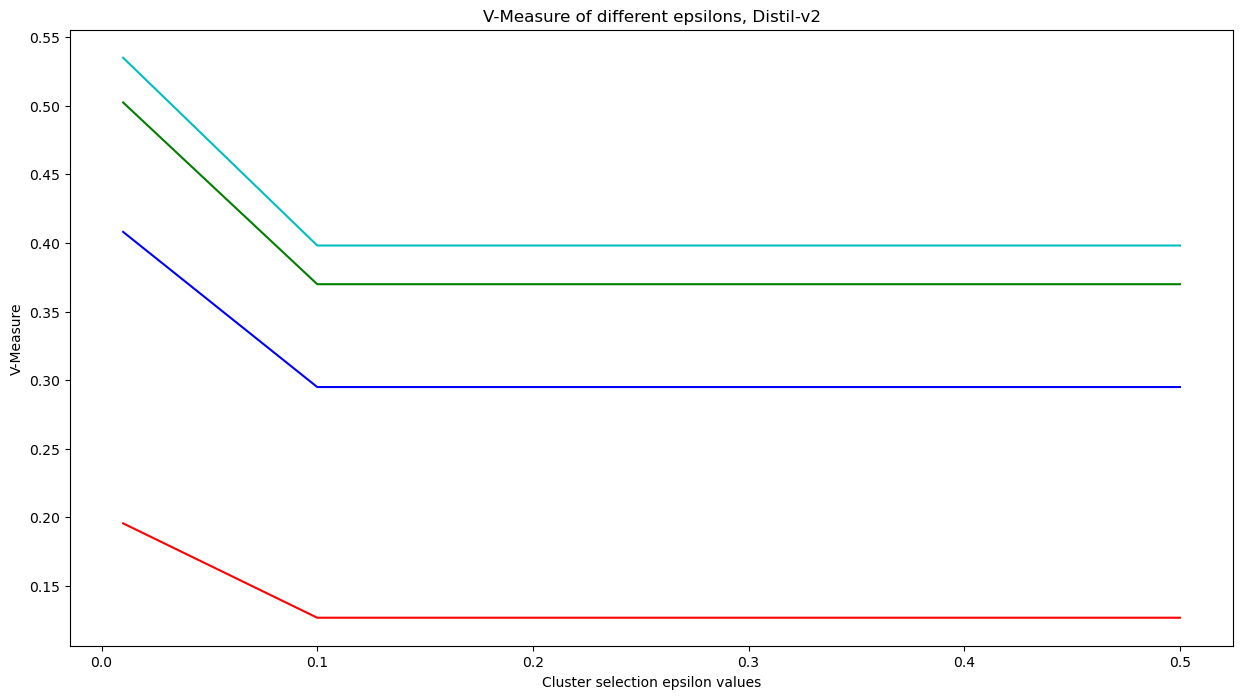

In [35]:
x_values = [0.01, 0.1, 0.5]

plot, ax = plt.subplots()
plt.plot(x_values,v_measures_df_paraph_distil2['layer_1'], 'r',
         x_values,v_measures_df_paraph_distil2['layer_2'], 'b',
         x_values,v_measures_df_paraph_distil2['layer_3'], 'g',
         x_values,v_measures_df_paraph_distil2['layer_4'], 'c')
plot.set_size_inches(15, 8)

ax.set_xlabel("Cluster selection epsilon values")
ax.set_ylabel("V-Measure")
ax.set_title("V-Measure of different epsilons, Distil-v2")

plt.show()

##### Homogeneity

In [25]:
print(homogeneity_score(layered_descriptions_filtered['layer_1'], cluster_labels_distil2))
print(homogeneity_score(layered_descriptions_filtered['layer_2'], cluster_labels_distil2))
print(homogeneity_score(layered_descriptions_filtered['layer_3'], cluster_labels_distil2))
print(homogeneity_score(layered_descriptions_filtered['layer_4'], cluster_labels_distil2))

0.5574764737747225
0.5007728651737358
0.47793510997162464
0.4660027138655035


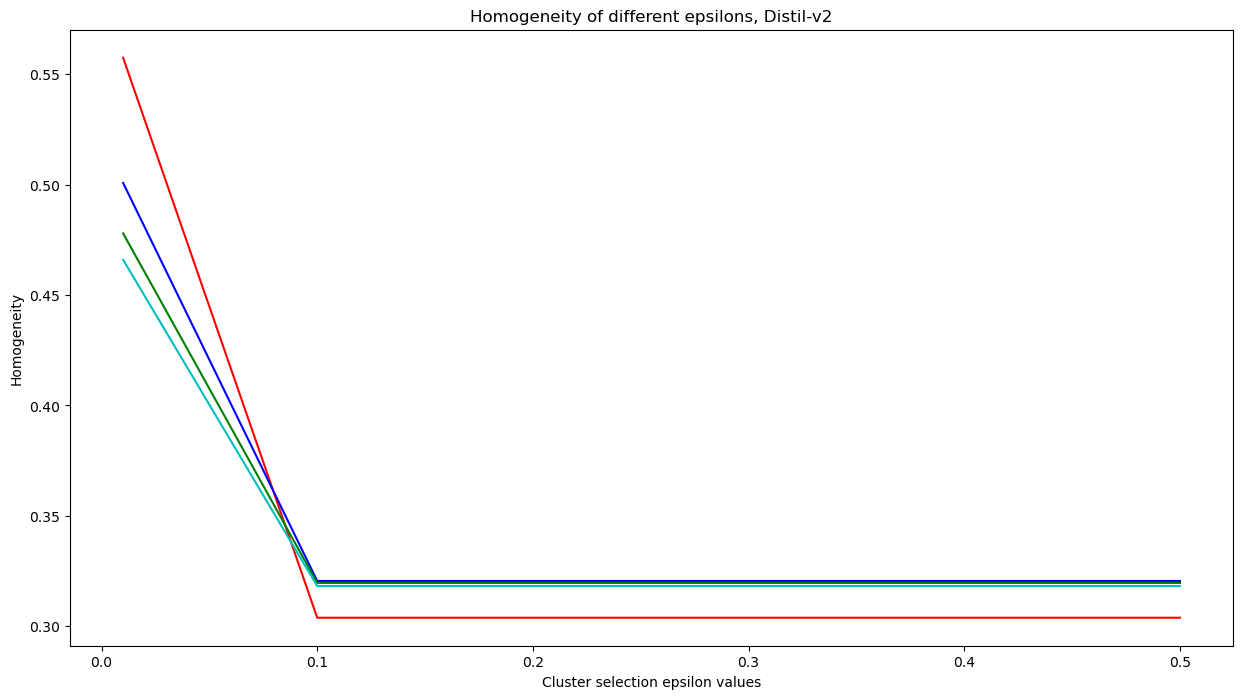

In [36]:
x_values = [0.01, 0.1, 0.5]

plot, ax = plt.subplots()
plt.plot(x_values,homogeneity_measures_df_paraph_distil2['layer_1'], 'r',
         x_values,homogeneity_measures_df_paraph_distil2['layer_2'], 'b',
         x_values,homogeneity_measures_df_paraph_distil2['layer_3'], 'g',
         x_values,homogeneity_measures_df_paraph_distil2['layer_4'], 'c')
plot.set_size_inches(15, 8)

ax.set_xlabel("Cluster selection epsilon values")
ax.set_ylabel("Homogeneity")
ax.set_title("Homogeneity of different epsilons, Distil-v2")

plt.show()

##### Completeness

In [26]:
print(completeness_score(layered_descriptions_filtered['layer_1'], cluster_labels_distil2))
print(completeness_score(layered_descriptions_filtered['layer_2'], cluster_labels_distil2))
print(completeness_score(layered_descriptions_filtered['layer_3'], cluster_labels_distil2))
print(completeness_score(layered_descriptions_filtered['layer_4'], cluster_labels_distil2))

0.11863630105635956
0.34424736246436444
0.5293181794142536
0.6277716053829951


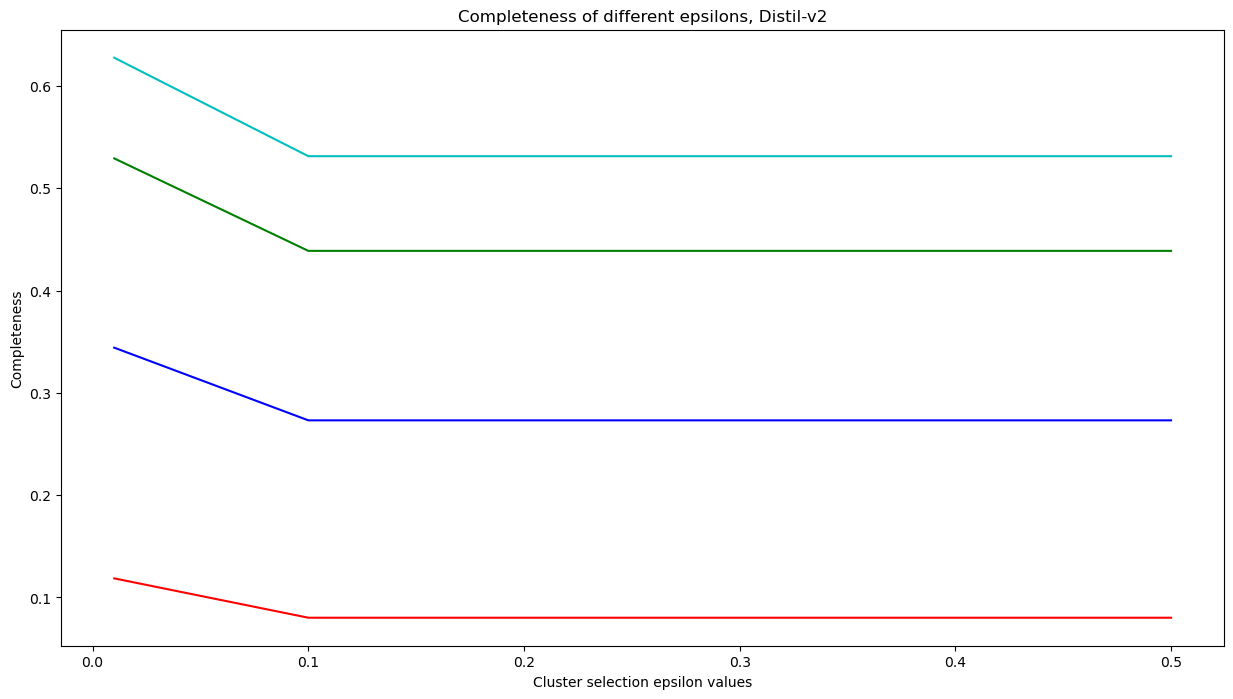

In [37]:
x_values = [0.01, 0.1, 0.5]

plot, ax = plt.subplots()
plt.plot(x_values,completness_measures_df_paraph_distil2['layer_1'], 'r',
         x_values,completness_measures_df_paraph_distil2['layer_2'], 'b',
         x_values,completness_measures_df_paraph_distil2['layer_3'], 'g',
         x_values,completness_measures_df_paraph_distil2['layer_4'], 'c')
plot.set_size_inches(15, 8)

ax.set_xlabel("Cluster selection epsilon values")
ax.set_ylabel("Completeness")
ax.set_title("Completeness of different epsilons, Distil-v2")

plt.show()

#### MiniLM

In [38]:
v_measures = []
homogeneity_measures = []
completeness_measures = []

v_measures_df_paraph_minlm = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])
homogeneity_measures_df_paraph_minilm = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])
completness_measures_df_paraph_minilm = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])

In [42]:
# calculating the v-measures for each of the subcategories/layers, and adding them to the v_measures_df dataframe
v_measures.append(v_measure_score(layered_descriptions_filtered['layer_1'], cluster_labels_minilm))
v_measures.append(v_measure_score(layered_descriptions_filtered['layer_2'], cluster_labels_minilm))
v_measures.append(v_measure_score(layered_descriptions_filtered['layer_3'], cluster_labels_minilm))
v_measures.append(v_measure_score(layered_descriptions_filtered['layer_4'], cluster_labels_minilm))

homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_1'], cluster_labels_minilm))
homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_2'], cluster_labels_minilm))
homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_3'], cluster_labels_minilm))
homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_4'], cluster_labels_minilm))

completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_1'], cluster_labels_minilm))
completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_2'], cluster_labels_minilm))
completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_3'], cluster_labels_minilm))
completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_4'], cluster_labels_minilm))


v_measures_df_paraph_minlm.loc[len(v_measures_df_paraph_minlm)] = v_measures
homogeneity_measures_df_paraph_minilm.loc[len(homogeneity_measures_df_paraph_minilm)] = homogeneity_measures
completness_measures_df_paraph_minilm.loc[len(completness_measures_df_paraph_minilm)] = completeness_measures

v_measures = []
homogeneity_measures = []
completeness_measures = []

v_measures_df_paraph_minlm.to_csv('calculated_files/evaluation_metric_dfs/v_measures_dbscan_minilm.csv', index=False)
homogeneity_measures_df_paraph_minilm.to_csv('calculated_files/evaluation_metric_dfs/homogene\ity_measures_dbscan_minilm.csv', index=False)
completness_measures_df_paraph_minilm.to_csv('calculated_files/evaluation_metric_dfs/completeness_measures_dbscan_minilm.csv', index=False)

v_measures_df_paraph_minlm = pd.read_csv('calculated_files/evaluation_metric_dfs/v_measures_dbscan_minilm.csv')
homogeneity_measures_df_paraph_minilm = pd.read_csv('calculated_files/evaluation_metric_dfs/homogene\ity_measures_dbscan_minilm.csv')
completness_measures_df_paraph_minilm = pd.read_csv('calculated_files/evaluation_metric_dfs/completeness_measures_dbscan_minilm.csv')


In [44]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(list(embedded_df_paraph_miniLM))


for epsilon in [0.1, 0.5]: 
    
    clusterer = HDBSCAN(min_cluster_size=10, n_jobs=8, cluster_selection_epsilon=epsilon)
    cluster_labels = clusterer.fit_predict(X_train)
    
    # calculating the v-measures for each of the subcategories/layers, and adding them to the v_measures_df dataframe
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_1'], cluster_labels))
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_2'], cluster_labels))
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_3'], cluster_labels))
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_4'], cluster_labels))

    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_1'], cluster_labels))
    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_2'], cluster_labels))
    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_3'], cluster_labels))
    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_4'], cluster_labels))

    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_1'], cluster_labels))
    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_2'], cluster_labels))
    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_3'], cluster_labels))
    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_4'], cluster_labels))


    v_measures_df_paraph_minlm.loc[len(v_measures_df_paraph_minlm)] = v_measures
    homogeneity_measures_df_paraph_minilm.loc[len(homogeneity_measures_df_paraph_minilm)] = homogeneity_measures
    completness_measures_df_paraph_minilm.loc[len(completness_measures_df_paraph_minilm)] = completeness_measures

    v_measures = []
    homogeneity_measures = []
    completeness_measures = []

    v_measures_df_paraph_minlm.to_csv('calculated_files/evaluation_metric_dfs/v_measures_dbscan_minilm.csv', index=False)
    homogeneity_measures_df_paraph_minilm.to_csv('calculated_files/evaluation_metric_dfs/homogene\ity_measures_dbscan_minilm.csv', index=False)
    completness_measures_df_paraph_minilm.to_csv('calculated_files/evaluation_metric_dfs/completeness_measures_dbscan_minilm.csv', index=False)

    v_measures_df_paraph_minlm = pd.read_csv('calculated_files/evaluation_metric_dfs/v_measures_dbscan_minilm.csv')
    homogeneity_measures_df_paraph_minilm = pd.read_csv('calculated_files/evaluation_metric_dfs/homogene\ity_measures_dbscan_minilm.csv')
    completness_measures_df_paraph_minilm = pd.read_csv('calculated_files/evaluation_metric_dfs/completeness_measures_dbscan_minilm.csv')




In [3]:
# np.save('calculated_files/hdbscan/lblcluster_MiniLM.npy', cluster_labels)
cluster_labels_minilm = np.load('calculated_files/hdbscan/lblcluster_MiniLM.npy', allow_pickle=True) 

In [4]:
unique_labels = np.unique(cluster_labels_minilm)
num_clusters = len(unique_labels[unique_labels != -1])

print("Number of Clusters:", num_clusters)

Number of Clusters: 3014


##### V-measure

In [28]:
print(v_measure_score(layered_descriptions_filtered['layer_1'], cluster_labels_minilm))
print(v_measure_score(layered_descriptions_filtered['layer_2'], cluster_labels_minilm))
print(v_measure_score(layered_descriptions_filtered['layer_3'], cluster_labels_minilm))
print(v_measure_score(layered_descriptions_filtered['layer_4'], cluster_labels_minilm))

0.16894166736736801
0.3640517978161604
0.4495879571475142
0.4812470250062444


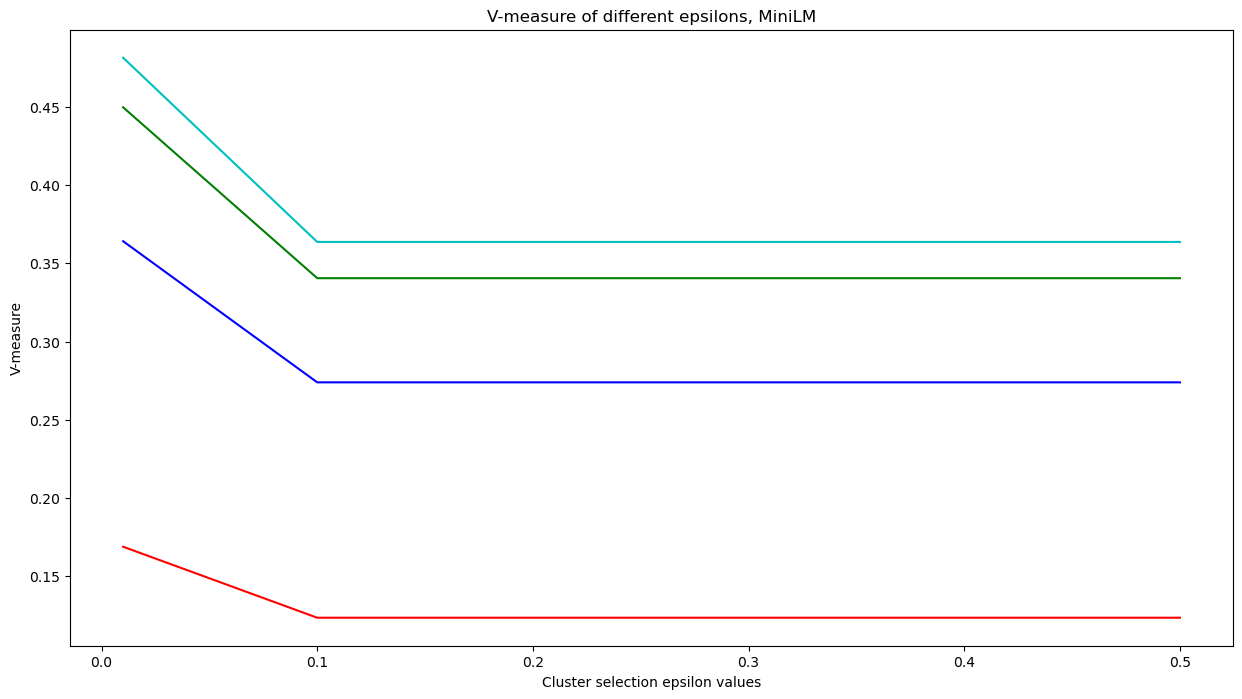

In [46]:
x_values = [0.01, 0.1, 0.5]

plot, ax = plt.subplots()
plt.plot(x_values,v_measures_df_paraph_minlm['layer_1'], 'r',
         x_values,v_measures_df_paraph_minlm['layer_2'], 'b',
         x_values,v_measures_df_paraph_minlm['layer_3'], 'g',
         x_values,v_measures_df_paraph_minlm['layer_4'], 'c')
plot.set_size_inches(15, 8)

ax.set_xlabel("Cluster selection epsilon values")
ax.set_ylabel("V-measure")
ax.set_title("V-measure of different epsilons, MiniLM")

plt.show()

##### Homogeneity

In [29]:
print(homogeneity_score(layered_descriptions_filtered['layer_1'], cluster_labels_minilm))
print(homogeneity_score(layered_descriptions_filtered['layer_2'], cluster_labels_minilm))
print(homogeneity_score(layered_descriptions_filtered['layer_3'], cluster_labels_minilm))
print(homogeneity_score(layered_descriptions_filtered['layer_4'], cluster_labels_minilm))

0.4455639360439533
0.42290926777047966
0.4094401319719255
0.4031141359208336


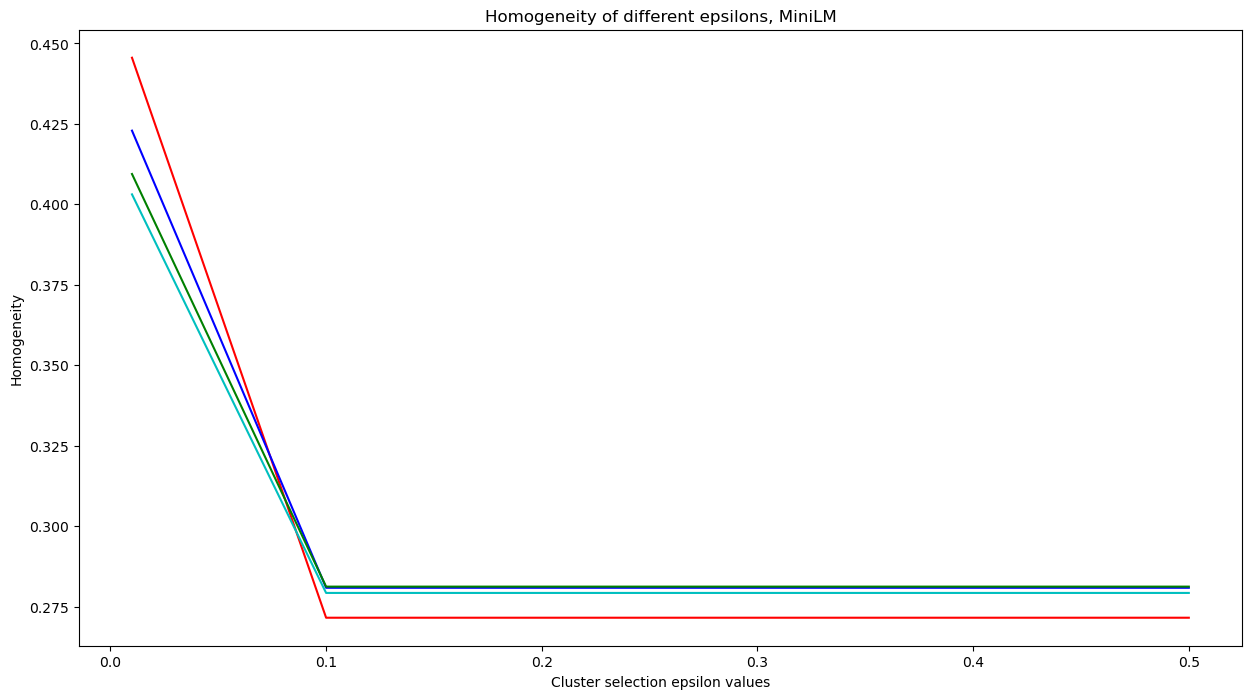

In [47]:
x_values = [0.01, 0.1, 0.5]

plot, ax = plt.subplots()
plt.plot(x_values,homogeneity_measures_df_paraph_minilm['layer_1'], 'r',
         x_values,homogeneity_measures_df_paraph_minilm['layer_2'], 'b',
         x_values,homogeneity_measures_df_paraph_minilm['layer_3'], 'g',
         x_values,homogeneity_measures_df_paraph_minilm['layer_4'], 'c')
plot.set_size_inches(15, 8)

ax.set_xlabel("Cluster selection epsilon values")
ax.set_ylabel("Homogeneity")
ax.set_title("Homogeneity of different epsilons, MiniLM")

plt.show()

##### Completeness

In [30]:
print(completeness_score(layered_descriptions_filtered['layer_1'], cluster_labels_minilm))
print(completeness_score(layered_descriptions_filtered['layer_2'], cluster_labels_minilm))
print(completeness_score(layered_descriptions_filtered['layer_3'], cluster_labels_minilm))
print(completeness_score(layered_descriptions_filtered['layer_4'], cluster_labels_minilm))

0.1042311716590618
0.3195755688158501
0.49846517005561564
0.5969497641447241


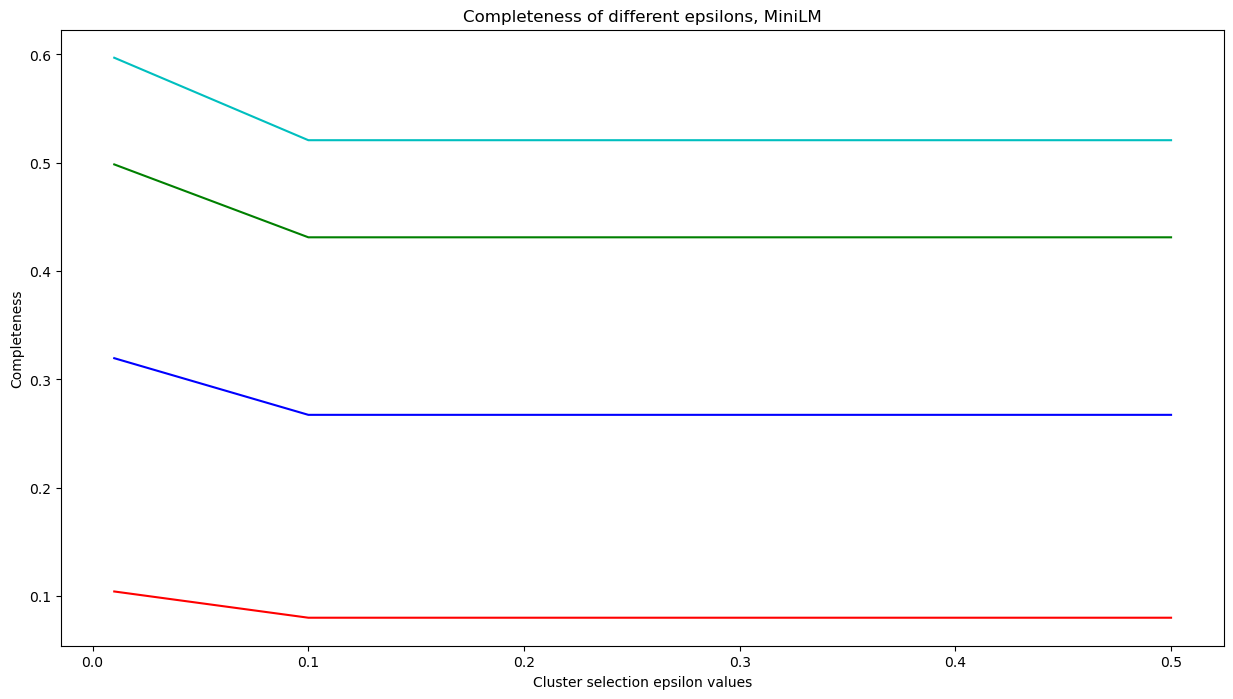

In [48]:
x_values = [0.01, 0.1, 0.5]

plot, ax = plt.subplots()
plt.plot(x_values,completness_measures_df_paraph_minilm['layer_1'], 'r',
         x_values,completness_measures_df_paraph_minilm['layer_2'], 'b',
         x_values,completness_measures_df_paraph_minilm['layer_3'], 'g',
         x_values,completness_measures_df_paraph_minilm['layer_4'], 'c')
plot.set_size_inches(15, 8)

ax.set_xlabel("Cluster selection epsilon values")
ax.set_ylabel("Completeness")
ax.set_title("Completeness of different epsilons, MiniLM")

plt.show()

#### MPnet

In [51]:
v_measures = []
homogeneity_measures = []
completeness_measures = []

v_measures_df_mpnet = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])
homogeneity_measures_df_mpnet = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])
completness_measures_df_mpnet = pd.DataFrame(columns=['layer_1', 'layer_2', 'layer_3', 'layer_4'])

In [54]:
# calculating the v-measures for each of the subcategories/layers, and adding them to the v_measures_df dataframe
v_measures.append(v_measure_score(layered_descriptions_filtered['layer_1'], cluster_labels_mpnet))
v_measures.append(v_measure_score(layered_descriptions_filtered['layer_2'], cluster_labels_mpnet))
v_measures.append(v_measure_score(layered_descriptions_filtered['layer_3'], cluster_labels_mpnet))
v_measures.append(v_measure_score(layered_descriptions_filtered['layer_4'], cluster_labels_mpnet))

homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_1'], cluster_labels_mpnet))
homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_2'], cluster_labels_mpnet))
homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_3'], cluster_labels_mpnet))
homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_4'], cluster_labels_mpnet))

completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_1'], cluster_labels_mpnet))
completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_2'], cluster_labels_mpnet))
completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_3'], cluster_labels_mpnet))
completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_4'], cluster_labels_mpnet))


v_measures_df_mpnet.loc[len(v_measures_df_mpnet)] = v_measures
homogeneity_measures_df_mpnet.loc[len(homogeneity_measures_df_mpnet)] = homogeneity_measures
completness_measures_df_mpnet.loc[len(completness_measures_df_mpnet)] = completeness_measures

v_measures = []
homogeneity_measures = []
completeness_measures = []

v_measures_df_mpnet.to_csv('calculated_files/evaluation_metric_dfs/v_measures_dbscan_mpnet.csv', index=False)
homogeneity_measures_df_mpnet.to_csv('calculated_files/evaluation_metric_dfs/homogene\ity_measures_dbscan_mpnet.csv', index=False)
completness_measures_df_mpnet.to_csv('calculated_files/evaluation_metric_dfs/completeness_measures_dbscan_mpnet.csv', index=False)

v_measures_df_paraph_minlm = pd.read_csv('calculated_files/evaluation_metric_dfs/v_measures_dbscan_mpnet.csv')
homogeneity_measures_df_mpnet = pd.read_csv('calculated_files/evaluation_metric_dfs/homogene\ity_measures_dbscan_mpnet.csv')
completness_measures_df_mpnet = pd.read_csv('calculated_files/evaluation_metric_dfs/completeness_measures_dbscan_mpnet.csv')


In [56]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(list(embedded_df_paraph_mpnet))

for epsilon in [0.1, 0.5]: 
    clusterer = HDBSCAN(min_cluster_size=10, n_jobs=8, cluster_selection_epsilon=epsilon)
    cluster_labels = clusterer.fit_predict(X_train)

    # calculating the v-measures for each of the subcategories/layers, and adding them to the v_measures_df dataframe
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_1'], cluster_labels))
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_2'], cluster_labels))
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_3'], cluster_labels))
    v_measures.append(v_measure_score(layered_descriptions_filtered['layer_4'], cluster_labels))

    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_1'], cluster_labels))
    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_2'], cluster_labels))
    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_3'], cluster_labels))
    homogeneity_measures.append(homogeneity_score(layered_descriptions_filtered['layer_4'], cluster_labels))

    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_1'], cluster_labels))
    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_2'], cluster_labels))
    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_3'], cluster_labels))
    completeness_measures.append(completeness_score(layered_descriptions_filtered['layer_4'], cluster_labels))


    v_measures_df_mpnet.loc[len(v_measures_df_mpnet)] = v_measures
    homogeneity_measures_df_mpnet.loc[len(homogeneity_measures_df_mpnet)] = homogeneity_measures
    completness_measures_df_mpnet.loc[len(completness_measures_df_mpnet)] = completeness_measures

    v_measures = []
    homogeneity_measures = []
    completeness_measures = []

    v_measures_df_mpnet.to_csv('calculated_files/evaluation_metric_dfs/v_measures_dbscan_mpnet.csv', index=False)
    homogeneity_measures_df_mpnet.to_csv('calculated_files/evaluation_metric_dfs/homogene\ity_measures_dbscan_mpnet.csv', index=False)
    completness_measures_df_mpnet.to_csv('calculated_files/evaluation_metric_dfs/completeness_measures_dbscan_mpnet.csv', index=False)

    v_measures_df_mpnet = pd.read_csv('calculated_files/evaluation_metric_dfs/v_measures_dbscan_mpnet.csv')
    homogeneity_measures_df_mpnet = pd.read_csv('calculated_files/evaluation_metric_dfs/homogene\ity_measures_dbscan_mpnet.csv')
    completness_measures_df_mpnet = pd.read_csv('calculated_files/evaluation_metric_dfs/completeness_measures_dbscan_mpnet.csv')



In [2]:
# np.save('calculated_files/hdbscan/lblcluster_MPnet.npy', cluster_labels)
cluster_labels_mpnet = np.load('calculated_files/hdbscan/lblcluster_MPnet.npy', allow_pickle=True) 


number of clusters

In [38]:
unique_labels = np.unique(cluster_labels_mpnet)
num_clusters = len(unique_labels[unique_labels != -1])

print("Number of Clusters:", num_clusters)

Number of Clusters: 3326


##### V-measure

In [32]:
print(v_measure_score(layered_descriptions_filtered['layer_1'], cluster_labels_mpnet))
print(v_measure_score(layered_descriptions_filtered['layer_2'], cluster_labels_mpnet))
print(v_measure_score(layered_descriptions_filtered['layer_3'], cluster_labels_mpnet))
print(v_measure_score(layered_descriptions_filtered['layer_4'], cluster_labels_mpnet))

0.17219412651865748
0.38175997805401723
0.4775629037668965
0.5134479206373478


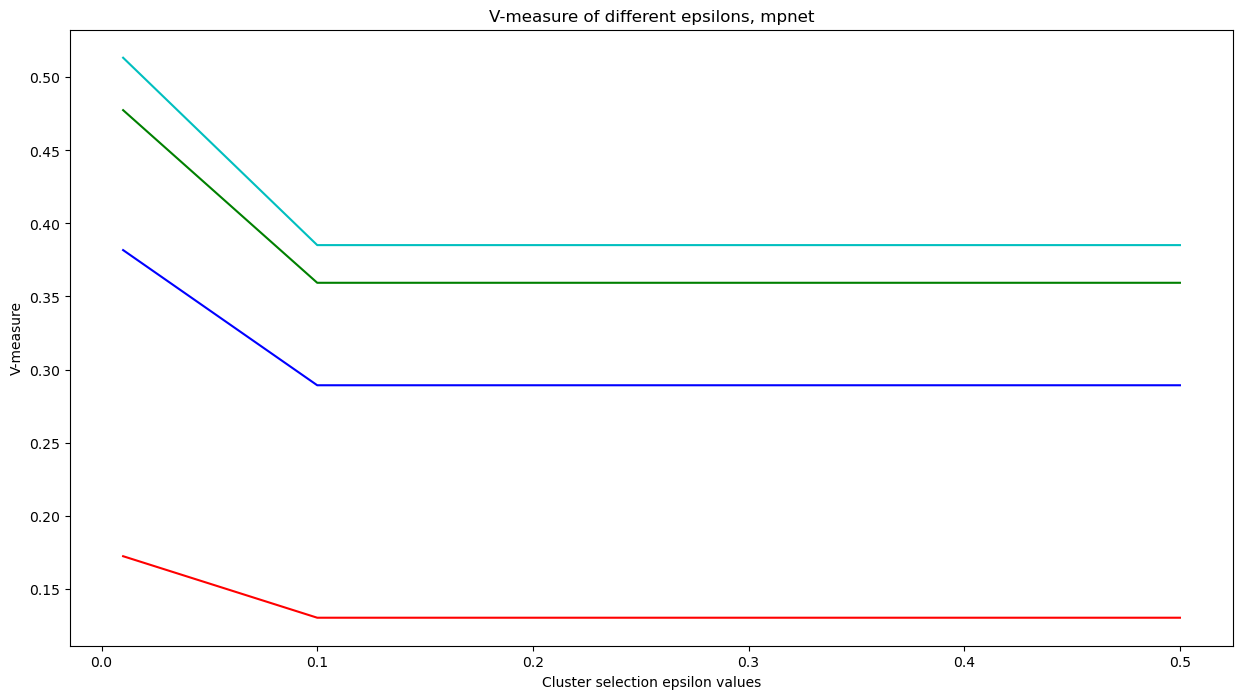

In [57]:
x_values = [0.01, 0.1, 0.5]

plot, ax = plt.subplots()
plt.plot(x_values,v_measures_df_mpnet['layer_1'], 'r',
         x_values,v_measures_df_mpnet['layer_2'], 'b',
         x_values,v_measures_df_mpnet['layer_3'], 'g',
         x_values,v_measures_df_mpnet['layer_4'], 'c')
plot.set_size_inches(15, 8)

ax.set_xlabel("Cluster selection epsilon values")
ax.set_ylabel("V-measure")
ax.set_title("V-measure of different epsilons, mpnet")

plt.show()

##### Homogeneity

In [33]:
print(homogeneity_score(layered_descriptions_filtered['layer_1'], cluster_labels_mpnet))
print(homogeneity_score(layered_descriptions_filtered['layer_2'], cluster_labels_mpnet))
print(homogeneity_score(layered_descriptions_filtered['layer_3'], cluster_labels_mpnet))
print(homogeneity_score(layered_descriptions_filtered['layer_4'], cluster_labels_mpnet))

0.4910838399818475
0.46883475579824546
0.4546037300296386
0.44748810057270677


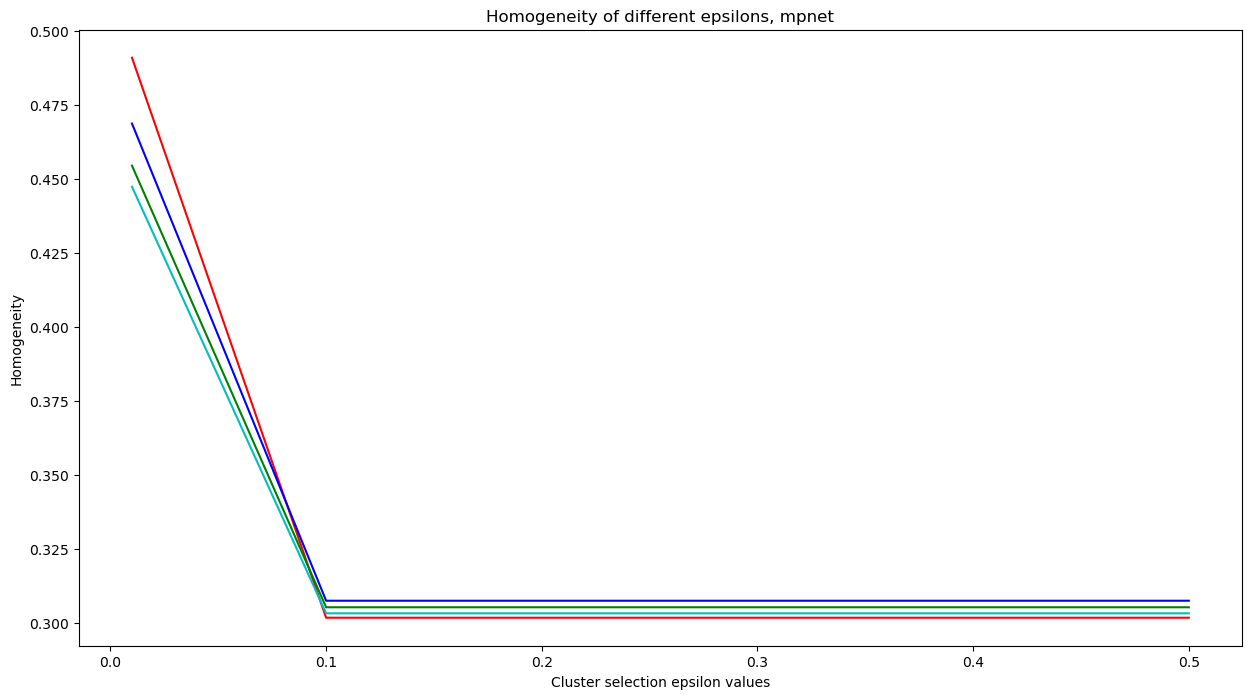

In [58]:
x_values = [0.01, 0.1, 0.5]

plot, ax = plt.subplots()
plt.plot(x_values,homogeneity_measures_df_mpnet['layer_1'], 'r',
         x_values,homogeneity_measures_df_mpnet['layer_2'], 'b',
         x_values,homogeneity_measures_df_mpnet['layer_3'], 'g',
         x_values,homogeneity_measures_df_mpnet['layer_4'], 'c')
plot.set_size_inches(15, 8)

ax.set_xlabel("Cluster selection epsilon values")
ax.set_ylabel("Homogeneity")
ax.set_title("Homogeneity of different epsilons, mpnet")

plt.show()

##### Completeness

In [34]:
print(completeness_score(layered_descriptions_filtered['layer_1'], cluster_labels_mpnet))
print(completeness_score(layered_descriptions_filtered['layer_2'], cluster_labels_mpnet))
print(completeness_score(layered_descriptions_filtered['layer_3'], cluster_labels_mpnet))
print(completeness_score(layered_descriptions_filtered['layer_4'], cluster_labels_mpnet))

0.10440063445706134
0.32196308083430947
0.5029644743837783
0.6022144267865231


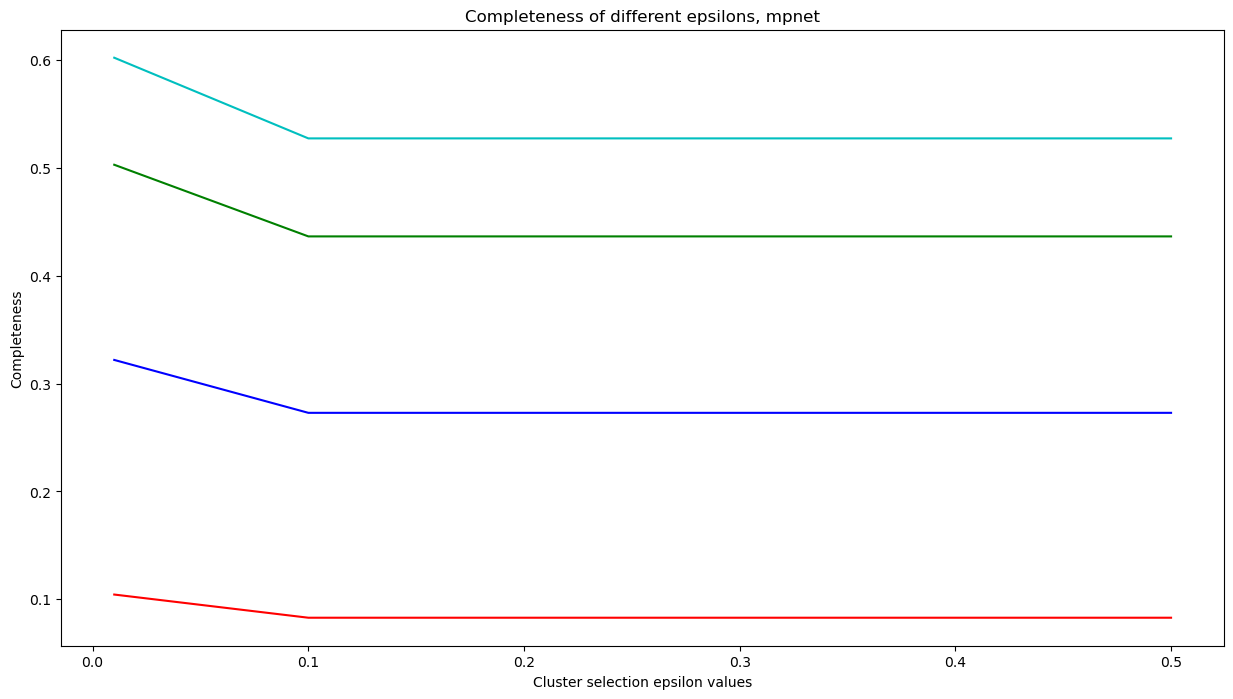

In [59]:
x_values = [0.01, 0.1, 0.5]

plot, ax = plt.subplots()
plt.plot(x_values,completness_measures_df_mpnet['layer_1'], 'r',
         x_values,completness_measures_df_mpnet['layer_2'], 'b',
         x_values,completness_measures_df_mpnet['layer_3'], 'g',
         x_values,completness_measures_df_mpnet['layer_4'], 'c')
plot.set_size_inches(15, 8)

ax.set_xlabel("Cluster selection epsilon values")
ax.set_ylabel("Completeness")
ax.set_title("Completeness of different epsilons, mpnet")

plt.show()

OOV Discovery (incomplete)

In [ ]:
embedded_df_distil_v1
distil_v1_st_model

In [ ]:
len(embedded_df_distil_v1[1])
len(embedded_df_distil_v1)

227910

In [ ]:
concat_merged_ds.shape

(227910,)

In [ ]:
layered_descriptions_filtered['concatenated'].shape

(227910,)

In [ ]:
unique = list(layered_descriptions_filtered['concatenated'].str.split(' ', expand=True).stack().unique())# Unique words
# unique

['Karteikarte',
 'zu',
 'Bl',
 'A',
 'SIGEL',
 '',
 'Stück',
 'Karten',
 'blanko',
 'weißzum',
 'Selbergestalten',
 'am',
 'PC',
 'Schreibmappe',
 'blau',
 'LEITZ',
 'Bebop',
 'm',
 'Schreibblock',
 'u',
 'Ablagefächern',
 'Sichthüllen',
 'StiftelascheCD',
 'uVisitenkartentasche',
 'BL',
 'lin',
 'perforiert',
 'Fach',
 'f',
 'Utensilien',
 'mit',
 'Beschriftungstaben',
 'Inkl',
 'Beschriftungsschildchen',
 'High',
 'Tech',
 'Material',
 'Mix',
 'langlebiges',
 'PP',
 'in',
 'Opaque',
 'schimmerndem',
 'Perlmutt',
 'Effekt',
 'Neuartige',
 'Oberflächenstruktur',
 'D',
 'Prägeart',
 'Innenseite',
 'Grau',
 'Ton',
 'Inkjetpatrone',
 'T',
 'foto',
 'sw',
 'EPSON',
 'ml',
 'schwarz',
 'Inhalt',
 'Epson',
 'Ink',
 'Stylus',
 'Pro',
 'photo',
 'black',
 'Plotterpapier',
 'mmxm',
 'weiß',
 'HP',
 'P',
 'g',
 'Inkjet',
 'Papier',
 'hochweiß',
 'sorgt',
 'für',
 'professionelle',
 'Qualität',
 'auch',
 'bei',
 'hohen',
 'Produktionsgeschwindigkeiten',
 'Dieses',
 'FSC',
 'zertifizierte',
 'bril

In [ ]:
len(unique)

146790

In [ ]:
encoded_unique = distil_v1_st_model.encode(unique)
# len(encoded_unique)

In [ ]:
len(encoded_unique)

146790

In [ ]:
encoded = distil_v1_st_model.encode("goojigoojigoo")
# distil_v1_st_model.decode(encoded)

AttributeError: 'SentenceTransformer' object has no attribute 'decode'

In [ ]:
distil_v1_st_model.get_vocab()

AttributeError: 'SentenceTransformer' object has no attribute 'get_vocab'